#### *Set up some initial python packages for analysis*

In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
from IPython.display import display, Image

In [17]:
#Read in metadata database as well to ensure 
database = pd.read_csv("./latest_metadata_database.csv", index_col = "ENA_sample_accessions")
database["poppunk_cluster"] = [int(x.split("_")[0]) for x in database["poppunk_cluster"].astype(str)]

/Users/nm12/anaconda/envs/jupyter/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (12,16,17,19,20,21,22,23,24,26,27,29,33,34,35,36,37,39,46,48,51,52,53,54,55,56,57,59,67,80,81) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [15]:
relevant_clusters = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,22,25,27,29,36]
meningitis_belt_countries = ["Burkina Faso", "Niger", "Ethiopia", "Mali", "Ghana", "Senegal", "Chad", 
                             "Guinea", "Gambia", " Guinea-Bissau", "Nigeria", "Cameroon", "Sudan", "Uganda", 
                             "South Sudan"]

# Clustering 13K mening genomes

In order to begin to analyse a collection of 13K isolates which spans both the globe and several decades, we need to be able to group these isolates into biologically accurate groups for downstream analysis, as current methods for analysing genome data, as well as the human minds' ability to store and analyse information, are simply unable to cope with genome data at the scale of 10K. [Poppunk](https://poppunk.readthedocs.io/en/latest/) is a particularly good way to do this for a number of reasons, but chiefly that it is fast, scaleable, and extensible, allowing us to add additional samples to a database after building it, enabling future research

So, we do a simple, straightforward run poppunk --easy-run on our collection. Doesn't work, hits run-time/memory wall. Looking at the distances, this is probably due to contamination on our dataset, in 13K isolates that is not too surprising. 

In [12]:
### OLD DETAILS NEED TO FILL ###
#                             #
#                             #
#                             #
### NEW WORK STARTS HERE ###

So, since there is some difficulty in actually getting a good poppunk fit for the whole collection, and sometimes even smaller collections that we assume we should be able to get a good fit for, let's work with collections that we know are feasible to work with, like the Dutch collection used to build a mening fit in the original poppunk [paper](https://genome.cshlp.org/content/29/2/304.full), and other datasets of 800 randomly subsampled isolates we know the provenance of.

When we assign isolates to these clusters, we get fairly reasonable results back in all cases, as per the histogram plots of each cluster and the number of isolates above. How can we know that the clusters created by these isolates are biologically accurate? A good way to test this is to compare the output clustering results of assignging the entire collection into different models built from 800 isolates, and seeing if the final clusters match up between the different runs. However, before we can do this, we need to re-index the clusters to ensure that they are numbered 1- $n$ with 1 being the largest cluster and $n$ being the smallest, as the random subsample we take, and then assigning the remaining of the qc-passed isolates can lead to different initial cluster sizes and subsequenct collapses

In [13]:
#Define a function to re-index the clusters
def reindex_clusters(sample_cluster_dic):
    #Get cluster sizes
    cluster_sizes = {}
    for key in sample_cluster_dic:
        cluster_sizes[sample_cluster_dic[key]] = cluster_sizes.get(int(sample_cluster_dic[key]), 0) + 1
    #Create a dictionary to match the original cluster names to their new names by size
    matchup_dictionary = {}
    for index in range(len(list(cluster_sizes.keys()))):
        matchup_dictionary[list(cluster_sizes.keys())[index]] = str(index+1)
    #Assign new cluster names to isolates
    reindexed_clusters = {}
    for sample in sample_cluster_dic:
        reindexed_clusters[sample] = matchup_dictionary[(sample_cluster_dic[sample])]
    return reindexed_clusters

In [39]:
#Open up and reindex the clusters

with open("./poppunk_data/12K_to_dutch.csv", 'r') as inhandle:
    lines = inhandle.read().splitlines()
assign12K_to_dutch_cluster_dic = {}
for line in lines[1:]:
    splitline = line.split(",")
    assign12K_to_dutch_cluster_dic[splitline[0]] = splitline[1]
    
dutch_reindexed = reindex_clusters(assign12K_to_dutch_cluster_dic)


with open("./poppunk_data/12K_to_random800-1_clusters.csv", 'r') as inhandle:
    lines = inhandle.read().splitlines()
assign12K_to_random800_1_cluster_dic = {}
for line in lines[1:]:
    splitline = line.split(",")
    assign12K_to_random800_1_cluster_dic[splitline[0]] = splitline[1]
    
random800_1_reindexed = reindex_clusters(assign12K_to_random800_1_cluster_dic)

with open("./poppunk_data/12K_to_random800-2_clusters.csv", 'r') as inhandle:
    lines = inhandle.read().splitlines()
assign12K_to_random800_2_cluster_dic = {}
for line in lines[1:]:
    splitline = line.split(",")
    assign12K_to_random800_2_cluster_dic[splitline[0]] = splitline[1]
    
random800_2_reindexed = reindex_clusters(assign12K_to_random800_2_cluster_dic)


In [42]:
#create a single dataframe of all these for easy comparison
dutch800_df = pd.DataFrame.from_dict(dutch_reindexed, orient="index", columns = ["Dutch"])
random800_1_df = pd.DataFrame.from_dict(random800_1_reindexed, orient="index", columns = ["Random800-1"])
random800_2_df = pd.DataFrame.from_dict(random800_2_reindexed, orient="index", columns = ["Random800-2"])

temp = pd.merge(dutch800_df, random800_1_df, left_index=True, right_index=True)
compare_assigned_clusters = pd.merge(temp, random800_2_df, left_index=True, right_index=True)

In [46]:
compare_assigned_clusters[compare_assigned_clusters["Random800-2"] != compare_assigned_clusters["Random800-1"]]

Dutch Random800-1 Random800-2
ERS389875      1           1           4
ERS3903480     1          98           1
ERS2922370     1          72          17
ERS1067074     1           1           2
ERS1067378     1           1           2
ERS1353620     1          21          13
ERS138329      1           6           1
ERS4396162     1          45          49
ERS1113395     1           1           2
ERS379133      1           4           6
ERS4396290     1          17          24
ERS4396574     1           2           1
ERS1353772     1           1           8
ERS1113172     1           1           2
ERS1112972     1           1           2
ERS1113423     1           1           2
ERS4026752     1          12           1
ERS323066      1           2           1
ERS1067333     1           1           2
ERS3903410     1         275           1
ERS3560984     1         130           1
ERS1113410     1           1           2
ERS1113769     1           1           2
ERS1353563     1          38          28
ERS1112961     1           1           2
ERS3208615     1          84           1
ERS1113414     1           1           2
ERS3560971     1           1           8
ERS1298010     1           1           4
ERS1297764     1           4           6
...          ...         ...         ...
ERS1067752   186           1           2
ERS1112988   187           1           2
ERS1113965   189           1           2
ERS1353683   196           3           1
ERS1353742   199          16           7
ERS138428    201          62           1
ERS138546    203           8           1
ERS138561    204          20          36
ERS1724894   213         201           7
ERS193727    216          15           9
ERS193805    222          25           3
ERS1984286   225          54          19
ERS209145    235           9           3
ERS209199    240           1           4
ERS209253    243          93           9
ERS209347    247           6           1
ERS209393    249          10           3
ERS2100996   252          12           1
ERS2101006   253           4           6
ERS234409    261           2           1
ERS234424    262           2           1
ERS248266    265           6           1
ERS2539300   269          43          51
ERS2539700   272          17           1
ERS3341740   276          53           8
ERS3740544   279          83          32
ERS378760    280         138           7
ERS4026847   289           3           1
ERS4293459   291          17           9
ERS4396423   294           2           1

[3899 rows x 3 columns]

In [47]:
compare_assigned_clusters[compare_assigned_clusters["Dutch"] != compare_assigned_clusters["Random800-1"]]

Dutch Random800-1 Random800-2
ERS3903480     1          98           1
ERS2922370     1          72          17
ERS1353620     1          21          13
ERS138329      1           6           1
ERS4396162     1          45          49
ERS4026761     1           3           3
ERS379133      1           4           6
ERS4396290     1          17          24
ERS4396574     1           2           1
ERS391653      1           3           3
ERS4026752     1          12           1
ERS323066      1           2           1
ERS1353596     1           5           5
ERS1353727     1           5           5
ERS3903410     1         275           1
ERS3560984     1         130           1
ERS1353563     1          38          28
ERS4026749     1           3           3
ERS3208615     1          84           1
ERS1353513     1           5           5
ERS3903487     1           5           5
ERS1297764     1           4           6
ERS2922317     1           2           1
ERS138332      1           8           3
ERS094810      1          10          29
ERS3341705     1          19           3
ERS4396264     1           2           1
ERS1353647     1           5           5
ERS3208603     1           3         128
ERS3189894     1         109          43
...          ...         ...         ...
ERS248266    265           6           1
ERS248359    266           1           1
ERS248425    267           1           1
ERS248490    268           1           1
ERS2539300   269          43          51
ERS2539306   270           1           1
ERS2539614   271           1           1
ERS2539700   272          17           1
ERS2922004   273           1           1
ERS2922259   274           1           1
ERS2922356   275           1           1
ERS3341740   276          53           8
ERS3560892   277           1           1
ERS3560900   278           1           1
ERS3740544   279          83          32
ERS378760    280         138           7
ERS378764    281           1           1
ERS378776    282           1           1
ERS378781    283           1           1
ERS378783    284           1           1
ERS378786    285           1           1
ERS378910    286           1           1
ERS378961    287           1           1
ERS379097    288           1           1
ERS4026847   289           3           1
ERS4026958   290           1           1
ERS4293459   291          17           9
ERS4395873   292           1           1
ERS4396320   293           1           1
ERS4396423   294           2           1

[9576 rows x 3 columns]

As can be seen from the above, in the best case, the clustering only agrees around 30% of the time, with 3899 isolates disagreeing in their cluster assignment in the best case, so it's clear that this approach is not going to work. This may mean that in general, it is inadvisable to generate a clustering on a subset of the data, or at least, probably not less than half the data (as was done in the PopPUNK paper). As half this collection already hits a runtime/memory usage wall, let's get back to basics, start with re-qcing the entire dataset, and seeing if we can walk through each step of the model construction manually to arrive at a clustering that makes sense. How will we know if it makes sense though? Will have to look for a method beyond internal consistency to validate this clustering, however. One approach may be to do what was done in the PopPUNK paper, and compare a the output of RhierBAPS on the core genome. We could use the panaroo-merge tool on a set of random subset panaroo runs to be able to get genes to align to the core genomes.

First, let's go right back to the qc step and qc again with a tool developed to quickly look at large collections of assembled isolates, [panaroo-qc](https://gtonkinhill.github.io/panaroo/#/quality/quality_control), which is really just a wrapper around [mash](https://mash.readthedocs.io/en/latest/tutorials.html) but includes some helpful output files and plots. If we load in this data we can make MDS distance plots which can help identify and remove the obvious outliers in terms of arbitrary k-mer distance:

In [11]:
#Read in MDS coordinates
coordinate_list = []
with open("./poppunk_data/mds_coords.txt", 'r') as mds_handle:
    for line in mds_handle.read().splitlines()[1:]:
        splitline = line.split()
        sample_dic = {splitline[0]:(float(splitline[1]),float(splitline[2]))}
        coordinate_list.append(sample_dic)

In [12]:
#define a function to help us plot a histogram of the genomes' MDS distances
def get_norm(x, y):
    norm_sum = (x**2) + (y**2)
    norm = math.sqrt(norm_sum)
    return norm

In [13]:
norm_list = [{list(x.keys())[0]: get_norm(list(x.values())[0][0], list(x.values())[0][1])} for x in coordinate_list]
norm_values = np.array([list(x.values())[0] for x in norm_list])

Let's first look at a distribution plot of distances to get rid of any immediately obviously outliers

(array([8.130e+02, 4.518e+03, 6.974e+03, 1.282e+03, 5.000e+00, 2.000e+00,
        4.000e+00, 3.000e+00, 4.000e+00, 4.600e+01, 1.150e+02, 1.800e+01,
        2.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 2.000e+00,
        8.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        2.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
        7.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        4.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 8.000e+00,
        0.000e+00, 3.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

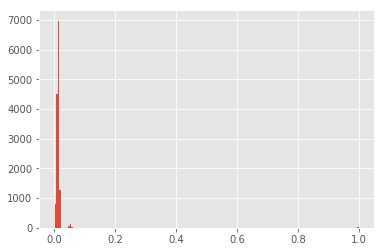

In [8]:
plt.hist(norm_values, bins=200)

As we can see, amost all the distances are very much less than 0.1, except for a tiny number of distances which are close to 1. These are obviously contamination and will interfere with our efforts to make a MDS scatterplot, so lets remove everything whose norm distances from the origin is greater than 0.2, to get rid of the ones near 1

In [17]:
filtered_norm_list = [x for x in norm_list if (list(x.values())[0] < 0.2)]
filtered_norm_keys = [list(x.keys())[0] for x in filtered_norm_list]
filtered_coordinate_list = [x for x in coordinate_list if (list(x.keys())[0] in filtered_norm_keys)]

#Split back into x and y coordinates for future scatterplotting
filt_cords_x = [list(x.values())[0][0] for x in filtered_coordinate_list]
filt_cords_y = [list(x.values())[0][1] for x in filtered_coordinate_list]

In [10]:
#See how many samples are left
len(filtered_coordinate_list)

13801

(array([1.300e+01, 2.100e+01, 4.400e+01, 6.200e+01, 5.500e+01, 3.370e+02,
        4.750e+02, 3.250e+02, 3.900e+02, 4.210e+02, 7.820e+02, 1.737e+03,
        6.650e+02, 9.850e+02, 3.039e+03, 9.470e+02, 9.710e+02, 5.930e+02,
        3.570e+02, 1.310e+02, 7.960e+02, 2.380e+02, 1.130e+02, 5.400e+01,
        3.000e+01, 6.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 3.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 3.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 2.000e+00, 1.000e+00,
        2.000e+00, 8.000e+00, 4.000e+00, 1.300e+01, 1.600e+01, 1.500e+01,
        6.000e+00, 2.100e+01, 2.200e+01, 2.800e+01, 2.200e+01, 6.000e+00,
        9.000e+00, 4.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

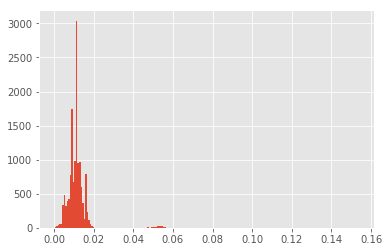

In [15]:
#scatterplot the filtered list to see how the new historgram looks 

plt.hist( np.array([list(x.values())[0] for x in filtered_norm_list]), bins=200)

This cuts down our initial input dataset from 13850 to 13801 isolates, removing 49. We can now make a scatterplot of these MDS coordinates to look for any other samples which look like outliers, like the ones between 0.04 and 0.06 on the above plot of magnitutde from the origin MDS

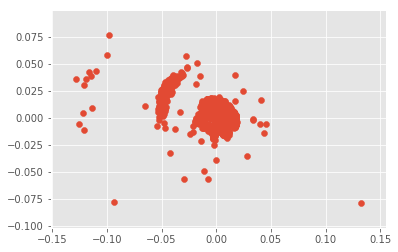

In [18]:
plt.scatter(filt_cords_x, filt_cords_y)

There are still some obvious contaminating points, let's see if we can apply a harsher filtering on distance from the origin and get rid of some of the genes which are further away from the origin. From the zoomed in histogram above, it seems like 0.04 is a sensible threshold for this filtering, to get rid of the second small peak between 0.04 and 0.06

In [19]:
harshfiltered_list = [x for x in norm_list if (list(x.values())[0] < 0.04)]
harshfiltered_norm_keys = [list(x.keys())[0] for x in harshfiltered_list]
harshfilt_coordinate_list = [x for x in coordinate_list if (list(x.keys())[0] in harshfiltered_norm_keys)]
harshfilt_cords_x = [list(x.values())[0][0] for x in harshfilt_coordinate_list]
harshfilt_cords_y = [list(x.values())[0][1] for x in harshfilt_coordinate_list]

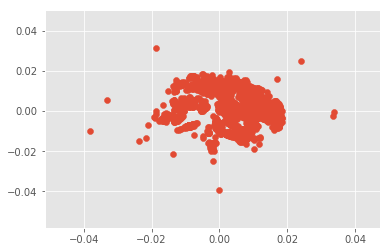

In [20]:
plt.scatter(harshfilt_cords_x, harshfilt_cords_y)

In [22]:
len(harshfilt_coordinate_list) #== len(harshfiltered_norm_keys)

13601

This has further reduced our input dataset by 200 isolates, and the plot is now looking pretty good. We're trying to get a functioning fit though without any of the issues from the previous effort, so why not be extra harsh? There are a few aditional isolates floating around which we may be able to take out by using a filter of distance from the origin <0.03

In [23]:
harshfiltered2_list = [x for x in norm_list if (list(x.values())[0] < 0.03)]
harshfiltered2_norm_keys = [list(x.keys())[0] for x in harshfiltered2_list]
harshfilt2_coordinate_list = [x for x in coordinate_list if (list(x.keys())[0] in harshfiltered2_norm_keys)]
harshfilt2_cords_x = [list(x.values())[0][0] for x in harshfilt2_coordinate_list]
harshfilt2_cords_y = [list(x.values())[0][1] for x in harshfilt2_coordinate_list]

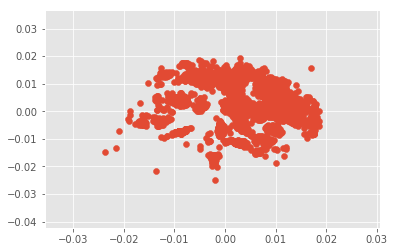

In [24]:
plt.scatter(harshfilt2_cords_x, harshfilt2_cords_y)

In [25]:
len(harshfilt2_coordinate_list)

13594

This has removed an additional 7 isolates, for a final dataset size of 13594. There are still some stragglers, but no reason to be lenient however, so let's try that again at a 0.02 threshold

In [14]:
harshfiltered3_list = [x for x in norm_list if (list(x.values())[0] < 0.02)]
harshfiltered3_norm_keys = [list(x.keys())[0] for x in harshfiltered3_list]
harshfilt3_coordinate_list = [x for x in coordinate_list if (list(x.keys())[0] in harshfiltered3_norm_keys)]
harshfilt3_cords_x = [list(x.values())[0][0] for x in harshfilt3_coordinate_list]
harshfilt3_cords_y = [list(x.values())[0][1] for x in harshfilt3_coordinate_list]

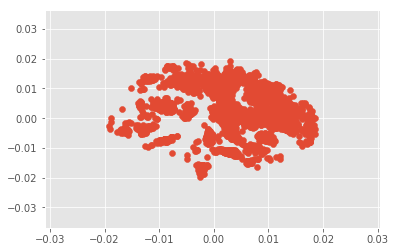

In [27]:
plt.scatter(harshfilt3_cords_x, harshfilt3_cords_y)

In [28]:
len(harshfilt3_coordinate_list)

13584

This has removed an additional 10 isolates. It might be a bit conservative, and is definitely more conservative than previously, but with a dataset as large as this, it is better to be safe than sorry. That means there are now 266 isoaltes to remove, lets find these isolates and write them out to a list:

In [15]:
to_remove = set([list(x.keys())[0] for x in norm_list]) - set([list(x.keys())[0] for x in harshfilt3_coordinate_list])
#with open("./poppunk_data/post_qc_isolates_to_remove.txt", 'w+') as outhandle:
    #for isolate in to_remove:
        #outhandle.write(isolate+'\n')

Though we've reduced the size of the dataset pretty considerably using this $k$-mer distance approach, lets also take a look at contig numbers and gene numbers just to make sure we've really cleaned up the dataset

In [16]:
#read in the contig number stats
contig_stats = pd.read_csv("./poppunk_data/ncontigs.txt", delim_whitespace=True)
#filter out the isolates removed in the previous step
clean_contig_stats = contig_stats[~contig_stats["sample"].isin(to_remove)]

In [38]:
#read in the gene number stats
ngene_stats = pd.read_csv("./poppunk_data/ngenes.txt", delim_whitespace=True)
#filter out the isolates removed in the previous step
clean_ngene_stats = ngene_stats[~ngene_stats["sample"].isin(to_remove)]

{'whiskers': [<matplotlib.lines.Line2D at 0x117e3c208>,
 'caps': [<matplotlib.lines.Line2D at 0x117b4a8d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x117e3c240>],
 'medians': [<matplotlib.lines.Line2D at 0x117e2b550>],
 'fliers': [<matplotlib.lines.Line2D at 0x117e2bf60>],
 'means': []}

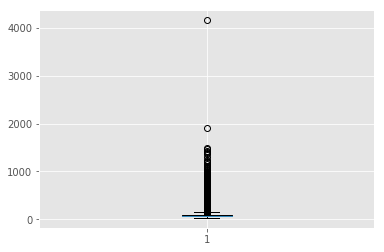

In [37]:
plt.boxplot(clean_contig_stats["no_contigs"])

{'whiskers': [<matplotlib.lines.Line2D at 0x119477668>,
 'caps': [<matplotlib.lines.Line2D at 0x119477cf8>,
 'boxes': [<matplotlib.lines.Line2D at 0x119477278>],
 'medians': [<matplotlib.lines.Line2D at 0x1194803c8>],
 'fliers': [<matplotlib.lines.Line2D at 0x119480710>],
 'means': []}

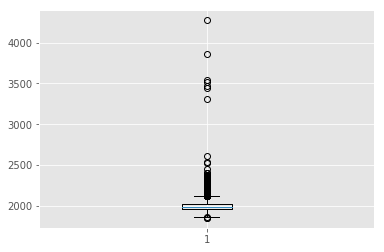

In [40]:
plt.boxplot(clean_ngene_stats["no_genes"])

Nice clean breaks there, at > 2000 contigs and > 3000 genes. Let's see which isolates those are and remove them:

In [41]:
#figure out which isolates are causing problems 
clean_contig_stats[clean_contig_stats["no_contigs"] > 3000]

sample  no_contigs
801  ERS094826      4157.0

In [42]:
clean_ngene_stats[clean_ngene_stats["no_genes"] > 3000]

sample  no_genes
801     ERS094826    4276.0
3940   ERS1297780    3538.0
4002   ERS1297929    3310.0
4004   ERS1297932    3856.0
6229    ERS248222    3520.0
8296   ERS3551199    3447.0
12804   ERS462644    3464.0

So, we can see that there are an additional 7 isolates with improbable numbers of genes ( > 3000) and one with a suspicious number of contigs also (>4000). Let's add these to the list of things to be removed and output the list again.

In [47]:
final_to_remove = set(clean_ngene_stats[clean_ngene_stats["no_genes"] > 3000]["sample"]).union(to_remove)
with open("./poppunk_data/post_qc_isolates_to_remove.txt", 'w+') as outhandle:
    for isolate in final_to_remove:
        outhandle.write(isolate+'\n')

In [46]:
len(set(clean_ngene_stats[clean_ngene_stats["no_genes"] > 3000]["sample"]))

7

As we were analysing the QC data, there have been reports from others in the team that the different backends for poppunk (mash vs. pp-sketchlib) have been giving different results due to distance calculation between poppunk 1 and 2, leading to irreproducable clusterings made with poppunk 1. This hasn't been my experience with the Dutch dataset, but let's just calculate the distances using both methods on the original qc'd dataset (not the one just done above_ and have a quick look at the distances to make sure they are the same:

In [3]:
mash_db_dists = pd.read_csv("./poppunk_data/global_db_mash.dists.out", delim_whitespace=True)

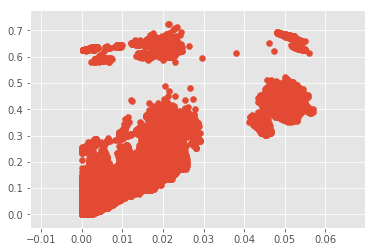

In [4]:
plt.scatter(mash_db_dists["Core"], mash_db_dists["Accessory"])

and by sketchlib:

In [7]:
sketchlib_db_dists = pd.read_csv("./poppunk_data/global_neisseria_db.dists.out", delim_whitespace=True)

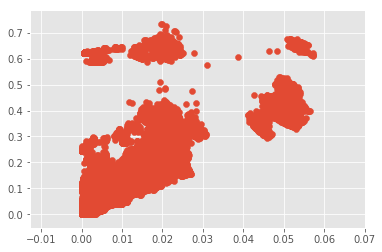

In [8]:
plt.scatter(sketchlib_db_dists["Core"], sketchlib_db_dists["Accessory"])

Looks like there's no difference there, so any issues probably aren't with the backend. Also ran a distance calculation on the redone qc with harsher cutoff of gene content, let's take a look at those distances:

In [10]:
newqc_sketchlib_dists = pd.read_csv("./poppunk_data/newqc_global_db.dists.out", delim_whitespace = True)

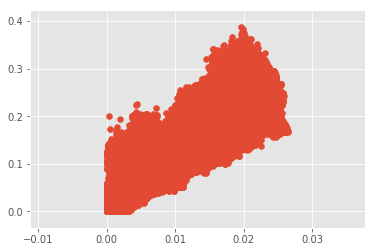

In [11]:
plt.scatter(newqc_sketchlib_dists["Core"], newqc_sketchlib_dists["Accessory"])

This looks much better, than before! No "floating" points with high accessory and low core distance. Also, no core distances going beyond 0.3 either, it's looking much more like "ideal" poppunk input. Were both those groups of points causing the issue though? We'll find out when we try to fit the model

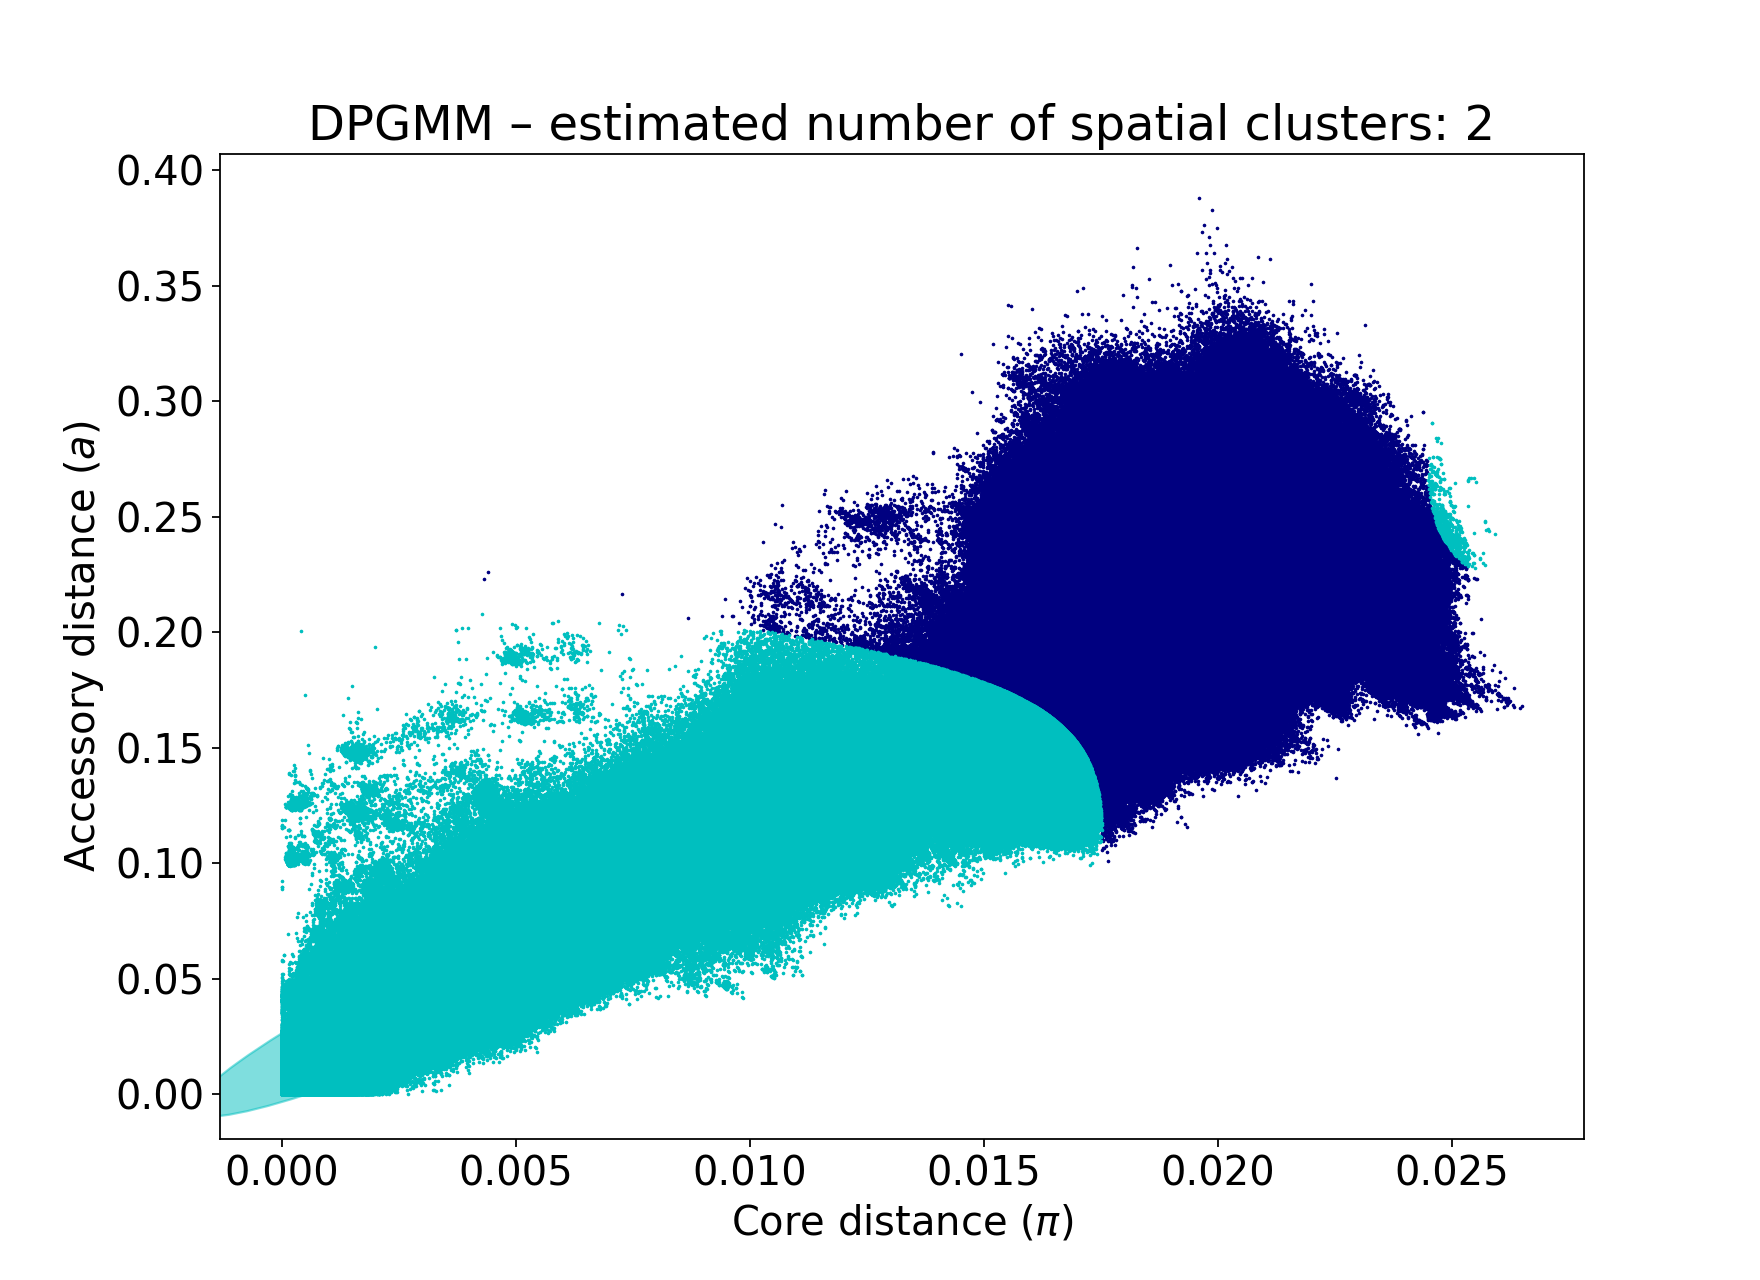

In [2]:
display(Image(filename='poppunk_data/newqc/global_fit/global_fit_DPGMM_fit.png'))

This fit looks OK, but seems to be suffering from issue that we expected _a priori_: that there is simply too much blur to get good initial fit boudaries, and the component near the origin includes some of the "blur" between the origin and the central mass. This happened with the initial GPS fit as well, and the refinement step was apparently created in order to deal with this issue We therefore need to refine the fit. As that's very slow however, let's do two other things just to see whether or not we thing that might actually work well. 1. Compare this initial fit to the initial fit of the dataset with the much less harsh QC, and 2. Look at how the initial fit actually looks by reading in the clustering and looking at the sizes of the clusters in the initial fit.

Here is the comparison plot from the previous whole dataset:

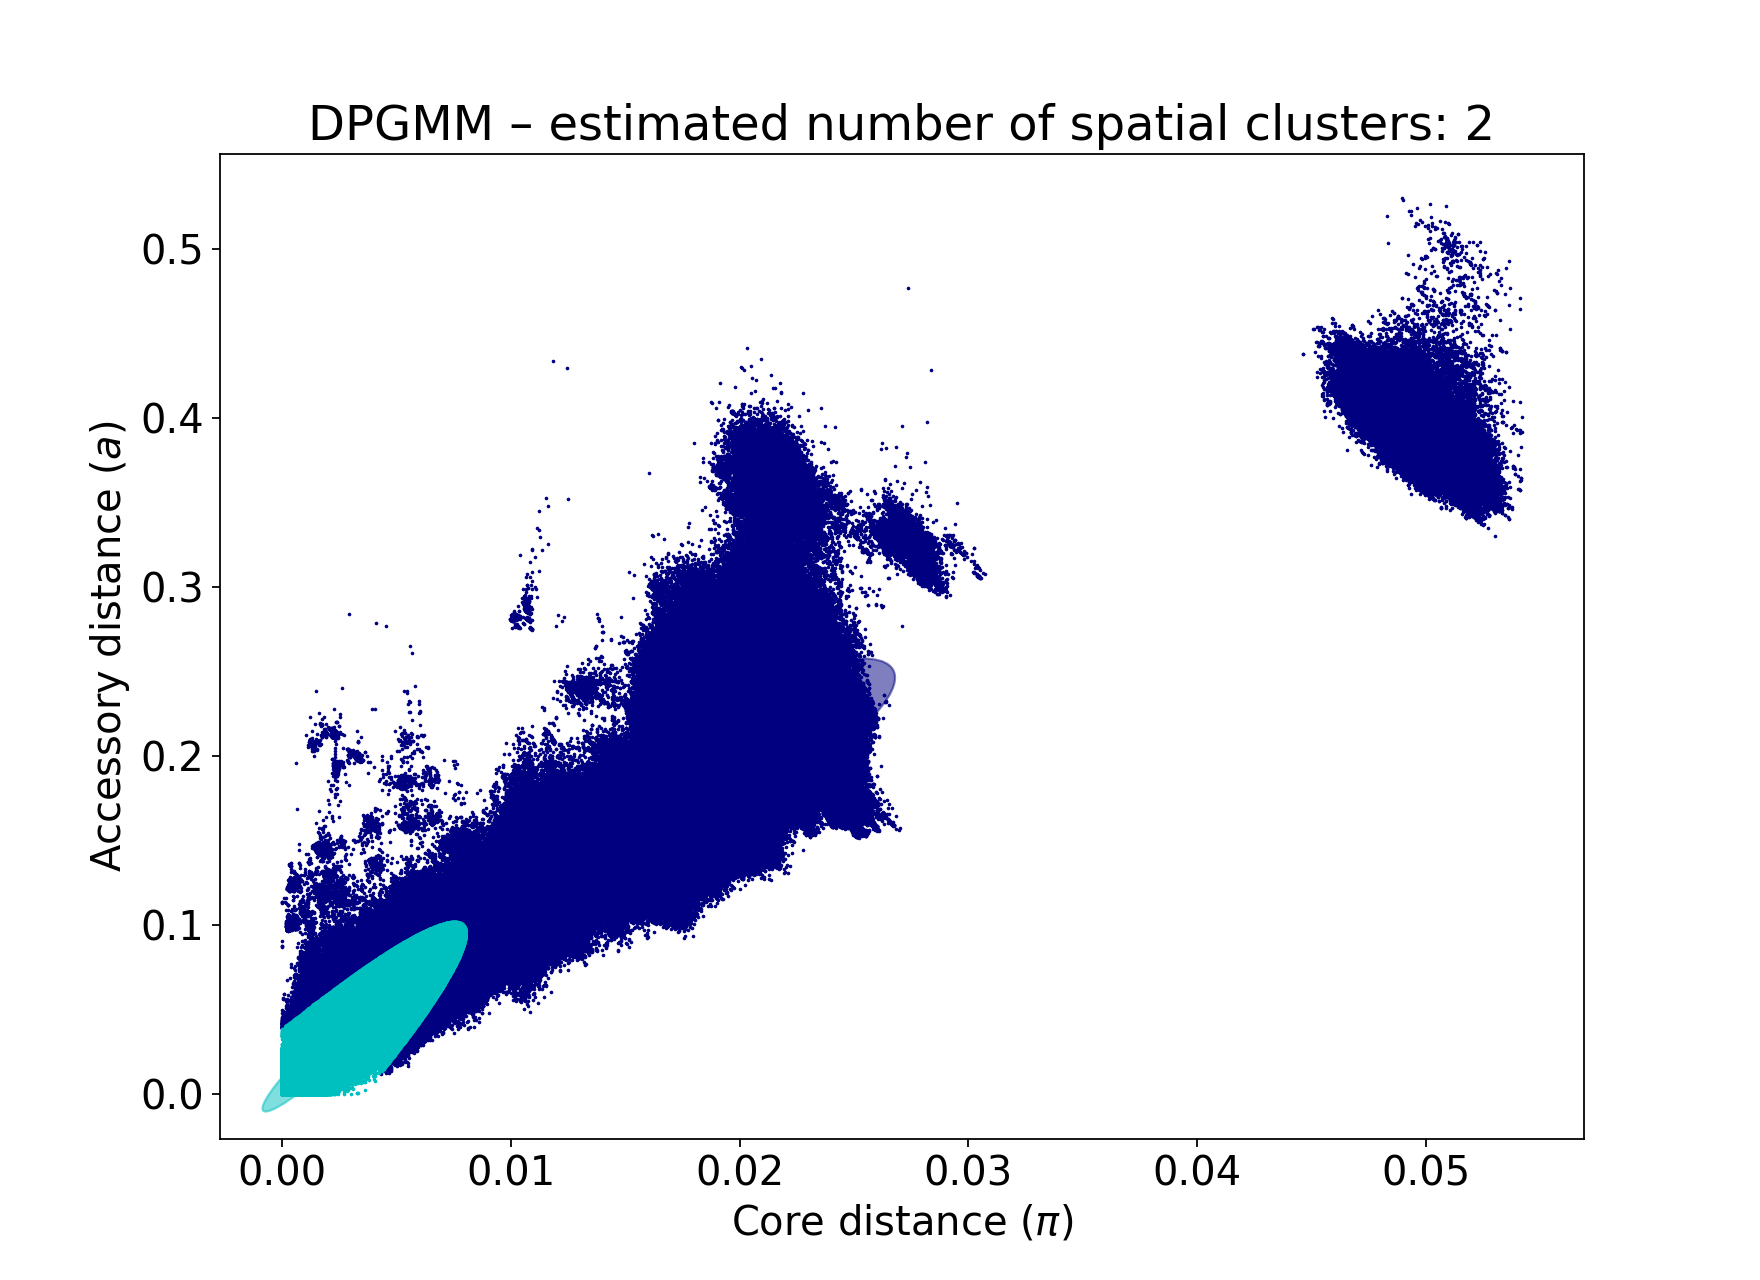

In [8]:
display(Image(filename='poppunk_data/newqc/global_fit/original_comparison.png'))

Reassuringly, the problem with the original dataset seems to be that the initial fit boudary didn't include enough of the "blur" and that was why it was trapped near the origin after fit refinement. With this new, cleaner dataset, hopefully it will be able to find a boundary that is actually similar to the one in the poppunk paper. Just how bad is the clustering though? If we look at it here:

In [5]:
unrefined_pp_fit = pd.read_csv("./poppunk_data/newqc/global_fit/global_fit_clusters.csv")

In [7]:
unrefined_pp_fit["Cluster"].value_counts()

1     13218
2       143
3        85
4        21
5        19
6        16
7        13
8        11
9         7
10        7
11        6
12        5
13        3
14        2
16        2
15        2
19        2
17        2
18        2
29        1
30        1
24        1
25        1
22        1
26        1
21        1
27        1
23        1
20        1
28        1
31        1
Name: Cluster, dtype: int64

It's clear that the clustering is far, far too permissive, with 13218 isolates falling into a single cluster. Hopefully this is resolved in the model refinement step, but we could also use this to try and speed up refinement, by directing the search to only look for more conservative thresholds by setting `--pos-shift` to $0$

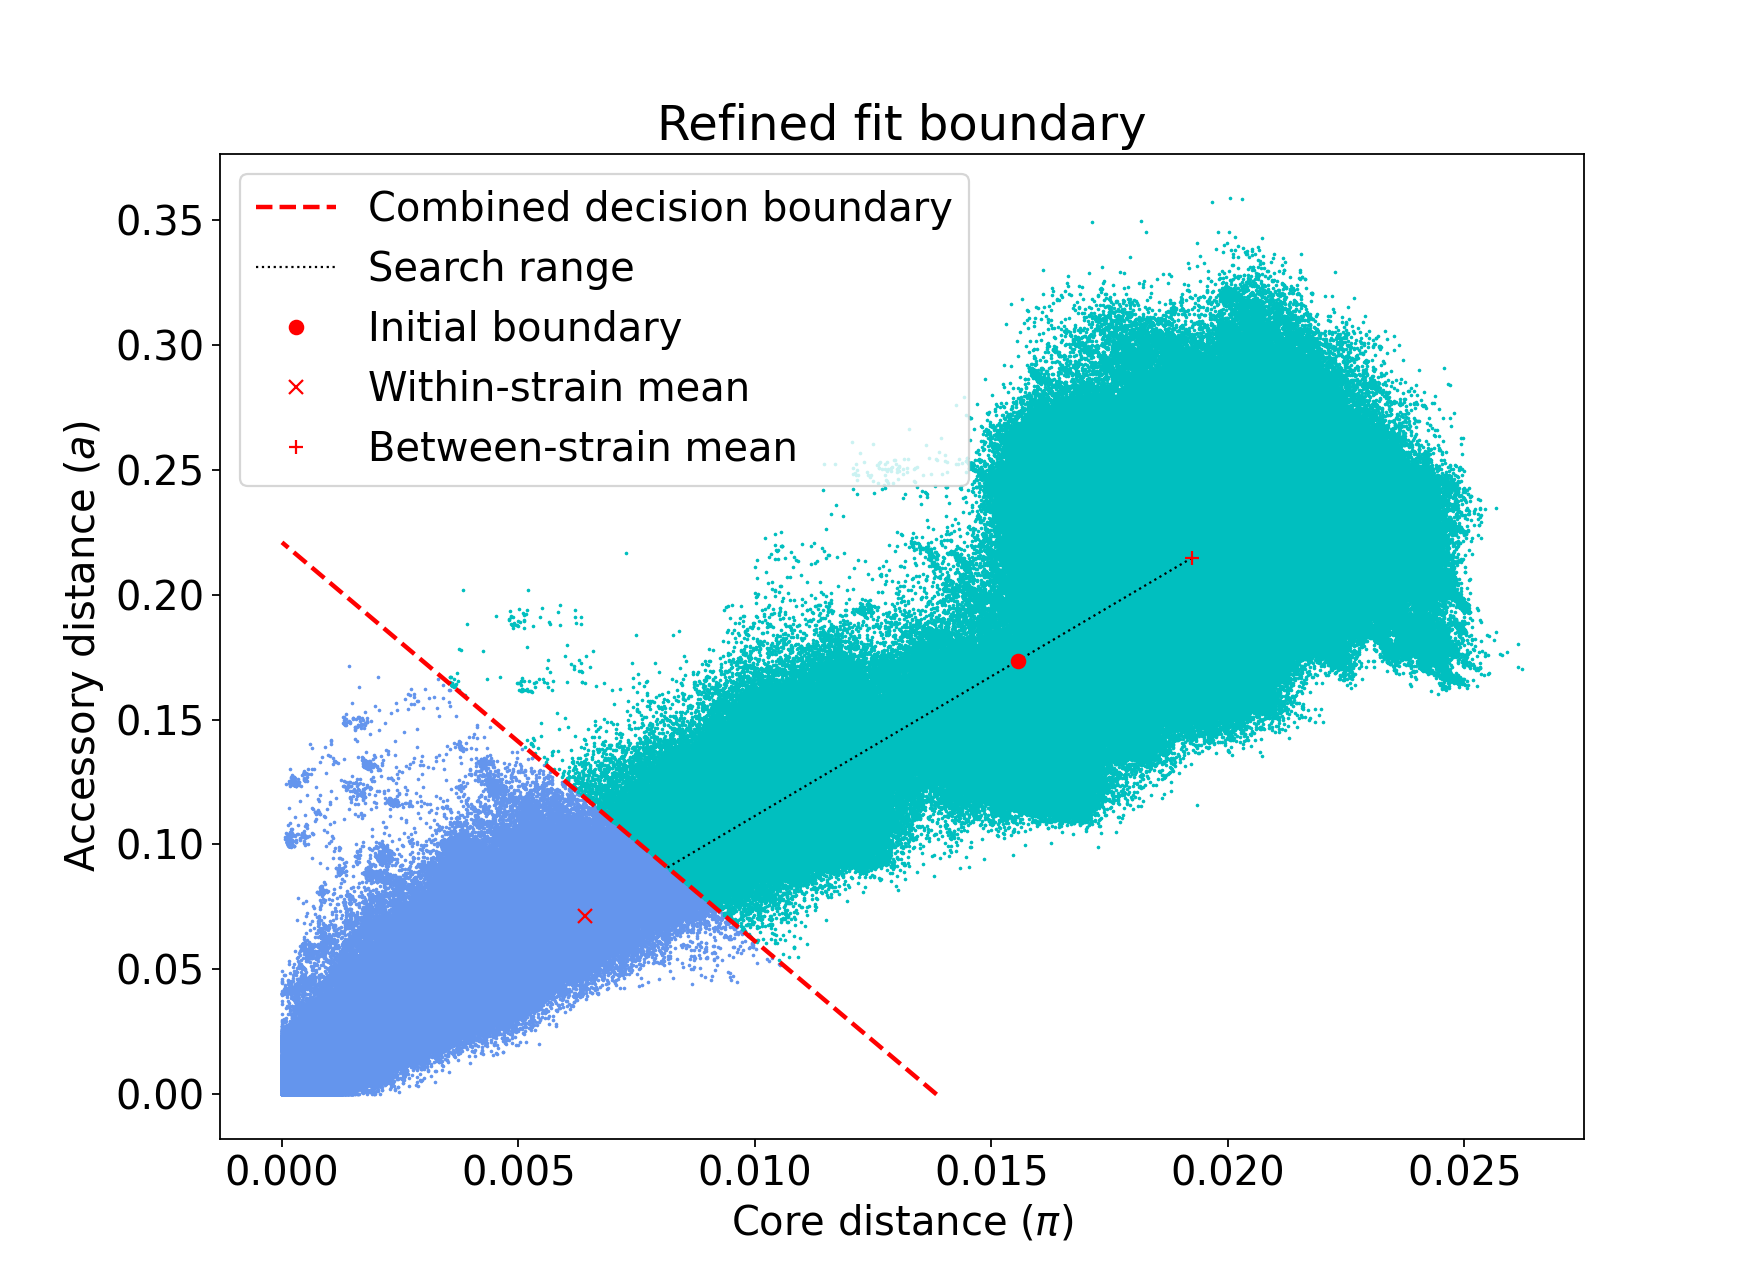

In [3]:
display(Image(filename='poppunk_data/newqc/global_refined_refined_fit.png'))

This refinement suggests that our initial view of the issue was correct, that the boudary was far too liberal, and has been refined to be more conservative. However, as it has reached the far end of the search range, we can't be sure that a better refinement doesn't exist do the left of the refined boundary. Let's increase the search range and try again

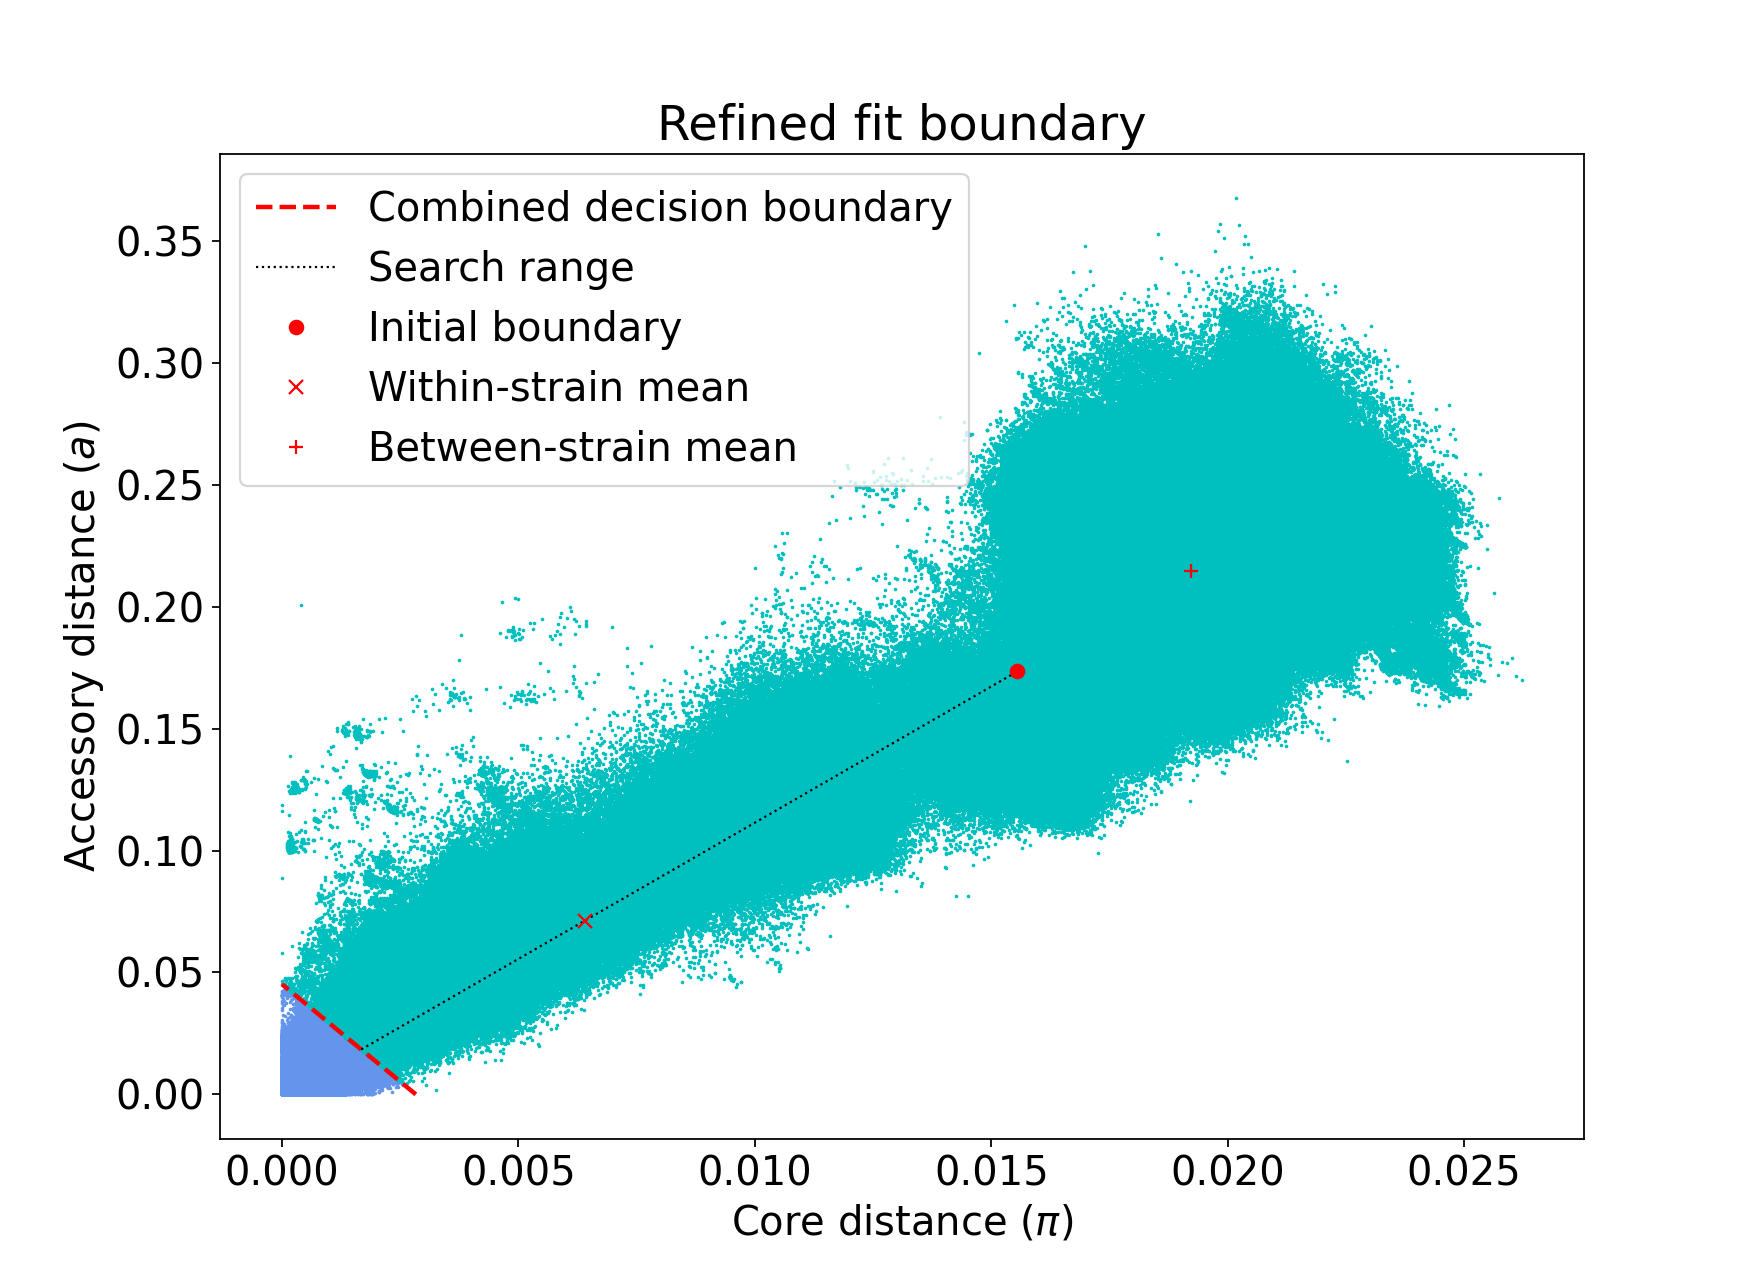

In [5]:
display(Image(filename='poppunk_data/newqc/global_refined_long3_refined_fit.png'))

This looks like the same issue, so we'll need to refine it even more:

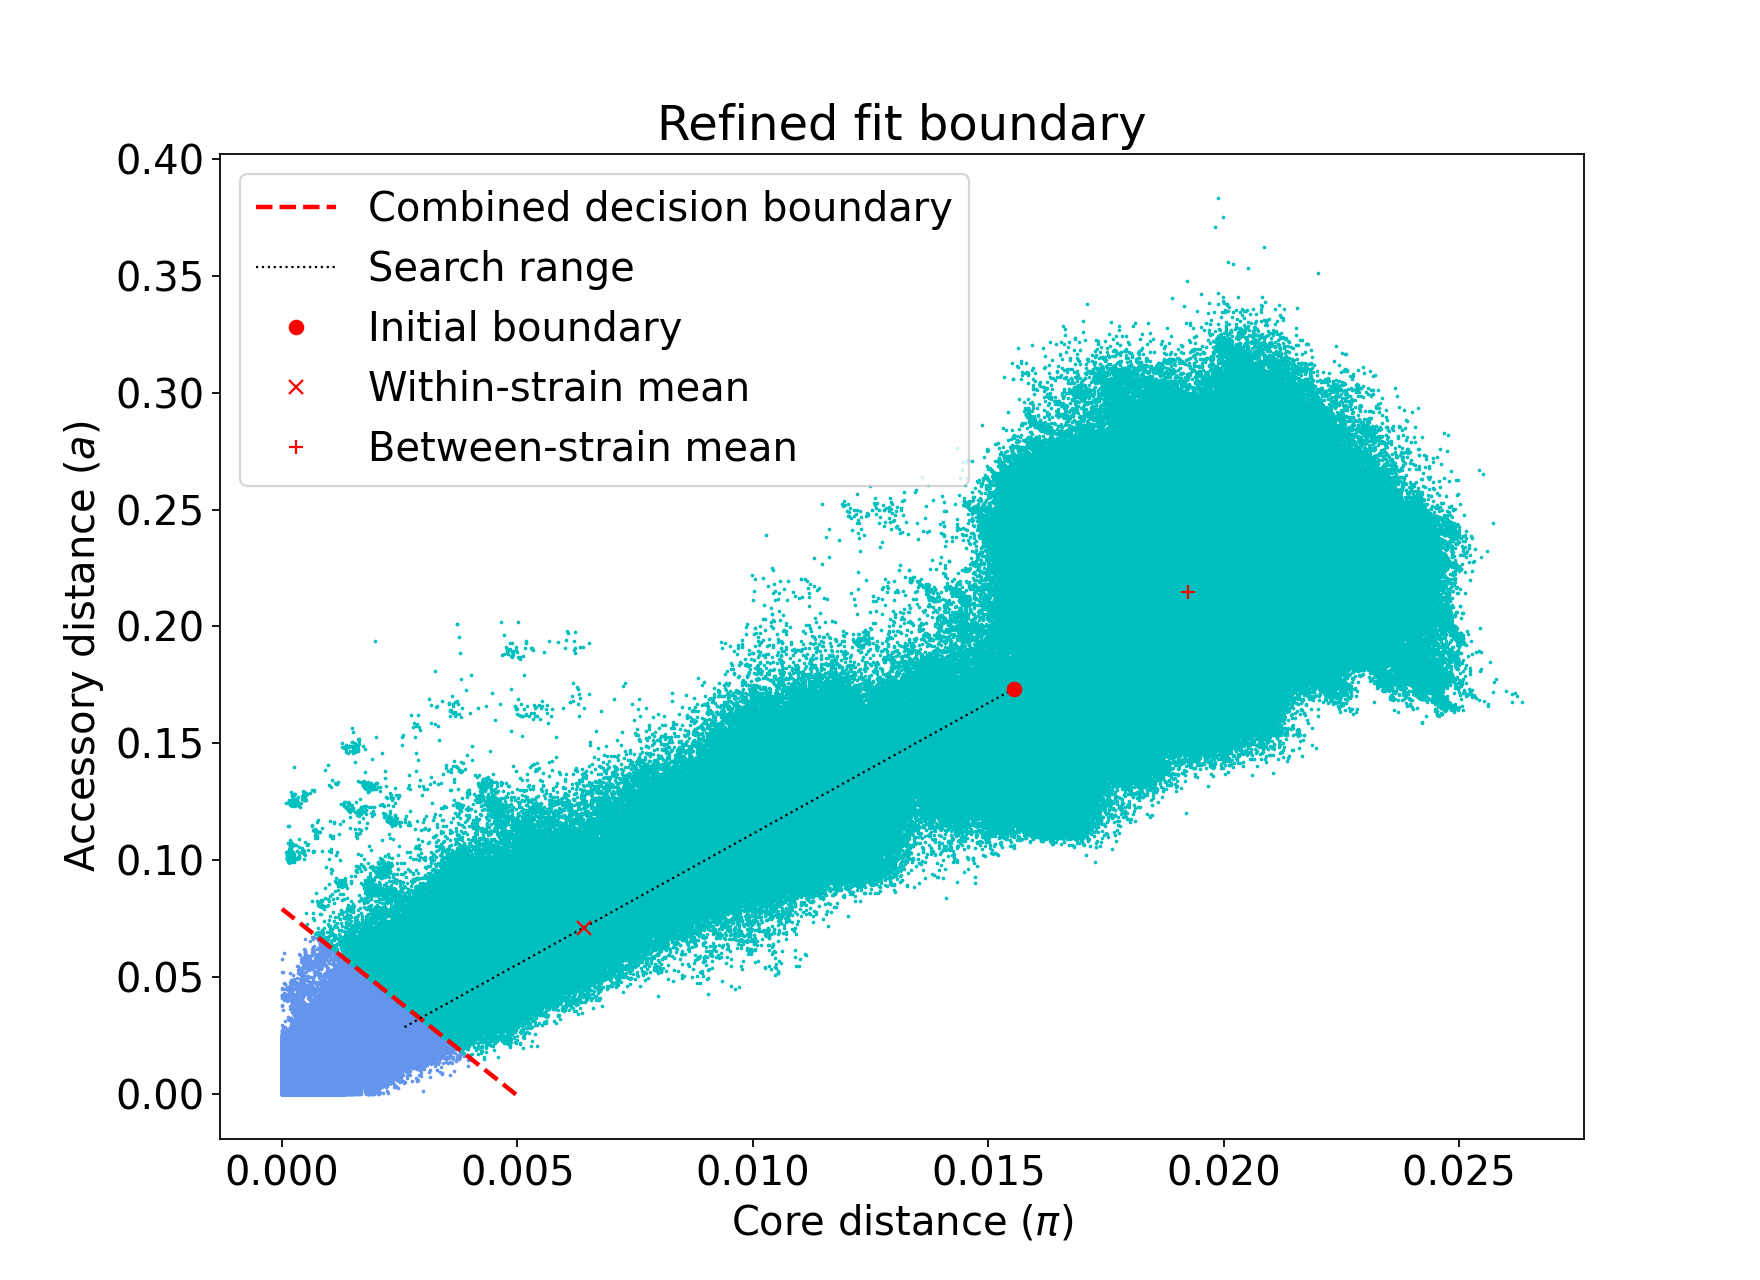

In [6]:
display(Image(filename='poppunk_data/newqc/global_refined_normal7_refined_fit.png'))

This looks a bit better, even though the search range is actually reduced from the previous. It seems like it's found a decision bounday which isnt' at the edge of the search range, which is encouraging. The next step is to look and see if the clusters make any sense, let's load them into this notebook

In [4]:
refined_newqc_clustering = pd.read_csv("./poppunk_data/newqc/global_refined_normal7_clusters.csv")

In [3]:
refined_newqc_clustering["Cluster"].value_counts()

1       2230
2       1444
3        886
4        816
5        678
6        628
7        546
8        470
9        433
10       358
11       337
12       278
13       275
14       224
15       222
16       204
17       131
18       122
19       119
20       108
21        71
22        70
23        69
24        67
25        64
26        57
27        57
28        56
29        41
30        32
        ... 
852        1
1076       1
972        1
1068       1
1060       1
1052       1
1044       1
1036       1
1028       1
1020       1
1012       1
1004       1
996        1
988        1
980        1
964        1
860        1
956        1
948        1
940        1
932        1
924        1
916        1
908        1
900        1
892        1
884        1
876        1
868        1
1187       1
Name: Cluster, Length: 1189, dtype: int64

In [12]:
refined_newqc_clustering["Cluster"].size#.value_counts().size

13578

In [5]:
refined_newqc_clustering["Cluster"].value_counts()[refined_newqc_clustering["Cluster"].value_counts() > 10]

1     2230
2     1444
3      886
4      816
5      678
6      628
7      546
8      470
9      433
10     358
11     337
12     278
13     275
14     224
15     222
16     204
17     131
18     122
19     119
20     108
21      71
22      70
23      69
24      67
25      64
26      57
27      57
28      56
29      41
30      32
      ... 
40      19
41      19
42      18
43      18
44      18
45      17
47      16
46      16
49      15
48      15
50      14
51      14
52      13
57      13
59      13
60      13
53      13
54      13
58      13
55      13
56      13
62      12
61      12
67      11
69      11
63      11
68      11
66      11
64      11
65      11
Name: Cluster, Length: 69, dtype: int64

This looks not bad -- 1 large cluster of 2230, then 1444, with 20 clusters having more than 100 isolates. 1187 clusters in total is not great, but perhaps not surprising given than mening is pretty diverse. Most importantly, 77% of isolates, or 10,509 out of 13579, are in clusters of larger than 100 isolates. We can now compare it to other clustering methods, the first one should probably be Serogroup as it is pretty broad-scale. Let's load the serogroup data:

In [24]:
serogroup_data = pd.read_csv("./poppunk_data/seroba_predictions.tsv", sep="\t")
serogroup_data

Taxon         Serogroup Contamination_t_or_f
0       ERS006830                 B                  NaN
1       ERS006833                 B                  NaN
2       ERS006838                 B        contamination
3       ERS006839  coverage too low                  NaN
4       ERS006840  coverage too low                  NaN
5       ERS006841  coverage too low                  NaN
6       ERS006842  coverage too low                  NaN
7       ERS006843  coverage too low                  NaN
8       ERS006846  coverage too low                  NaN
9       ERS006847  coverage too low                  NaN
10      ERS006848  coverage too low                  NaN
11      ERS006849  coverage too low                  NaN
12      ERS006850  coverage too low                  NaN
13      ERS006851  coverage too low                  NaN
14      ERS006852  coverage too low                  NaN
15      ERS006853  coverage too low                  NaN
16      ERS006854  coverage too low                  NaN
17      ERS006855  coverage too low                  NaN
18      ERS006856  coverage too low                  NaN
19      ERS006857  coverage too low                  NaN
20      ERS006858  coverage too low                  NaN
21      ERS006859  coverage too low                  NaN
22      ERS006860  coverage too low                  NaN
23      ERS006861  coverage too low                  NaN
24      ERS006862  coverage too low                  NaN
25      ERS006863  coverage too low                  NaN
26      ERS006864  coverage too low                  NaN
27      ERS006865  coverage too low                  NaN
28      ERS006866  coverage too low                  NaN
29      ERS006867  coverage too low                  NaN
...           ...               ...                  ...
13760  ERS3551261                 B        contamination
13761  ERS3551262                 B                  NaN
13762  ERS3551263                 C                  NaN
13763  ERS3551264                 B        contamination
13764  ERS3551265                 B                  NaN
13765  ERS3551266                 B                  NaN
13766  ERS3551267                 B        contamination
13767  ERS3551268                 B        contamination
13768  ERS3551269                 B                  NaN
13769  ERS3551270                 B                  NaN
13770  ERS3551271                 B                  NaN
13771  ERS3551272                 B                  NaN
13772  ERS3551273                 B                  NaN
13773  ERS3551275                 B                  NaN
13774  ERS3551276                 B                  NaN
13775  ERS3551278                 A        contamination
13776  ERS3551279                 B                  NaN
13777  ERS3551293                 A                  NaN
13778  ERS3551294                 A        contamination
13779  ERS3551296                 A                  NaN
13780  ERS3551298                 A                  NaN
13781  ERS3551299                 A        contamination
13782  ERS3551391                 A                  NaN
13783  ERS3551392                 A        contamination
13784  ERS3551394                 A                  NaN
13785  ERS3551395                 A                  NaN
13786  ERS3551396                 A        contamination
13787  ERS3552123  coverage too low                  NaN
13788  ERS3552127                 A                  NaN
13789  ERS3552385                 A        contamination

[13790 rows x 3 columns]

In [16]:
#cluster_and_serogroup = pd.merge(refined_newqc_clustering, serogroup_data, how="inner")
cluster_and_serogroup = database[]

Let's now look cluster-by-cluster to see how many serogroups are within a cluster on average:

In [17]:
cluster_and_serogroup[cluster_and_serogroup["Cluster"]==1]["Serogroup"].value_counts()

W_cc11              1889
C                    273
Y                     25
B                     24
coverage too low      12
Name: Serogroup, dtype: int64

In [18]:
cluster_and_serogroup[cluster_and_serogroup["Cluster"]==2]["Serogroup"].value_counts()

X    1436
Name: Serogroup, dtype: int64

In [19]:
cluster_and_serogroup[cluster_and_serogroup["Cluster"]==3]["Serogroup"].value_counts()

B                   824
coverage too low     44
untypable            10
C                     4
Y                     2
Name: Serogroup, dtype: int64

In [20]:
cluster_and_serogroup[cluster_and_serogroup["Cluster"]==4]["Serogroup"].value_counts()

untypable    815
A              1
Name: Serogroup, dtype: int64

In [21]:
cluster_and_serogroup[cluster_and_serogroup["Cluster"]==5]["Serogroup"].value_counts()

Y                   643
coverage too low     33
Name: Serogroup, dtype: int64

In [22]:
cluster_and_serogroup[cluster_and_serogroup["Cluster"]==6]["Serogroup"].value_counts()

B                   607
coverage too low     14
C                     6
Y                     1
Name: Serogroup, dtype: int64

In [23]:
cluster_and_serogroup[cluster_and_serogroup["Cluster"]==7]["Serogroup"].value_counts()

Y                   492
coverage too low     53
Name: Serogroup, dtype: int64

In [25]:
cluster_and_serogroup[cluster_and_serogroup["Cluster"]==8]["Serogroup"].value_counts()

A                   458
coverage too low     11
untypable             1
Name: Serogroup, dtype: int64

In [26]:
cluster_and_serogroup[cluster_and_serogroup["Cluster"]==9]["Serogroup"].value_counts()

Y            432
untypable      1
Name: Serogroup, dtype: int64

In [27]:
cluster_and_serogroup[cluster_and_serogroup["Cluster"]==10]["Serogroup"].value_counts()

C                   295
B                    55
untypable             4
coverage too low      3
Name: Serogroup, dtype: int64

In [2]:
database = pd.read_csv("./metdata/latest_metadata_database.csv")
database["poppunk_cluster"] = [int(x.split("_")[0]) for x in database["poppunk_cluster"].astype(str)]

/Users/nm12/anaconda/envs/jupyter/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (12,16,17,19,20,21,22,23,24,26,27,29,33,34,35,36,37,39,46,48,51,52,53,54,55,56,57,59,67,80,81) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [54]:
cluster_and_serogroup = database[["ENA_sample_accessions", "poppunk_cluster", 'seroba_prediction']]

In [55]:
cluster_and_serogroup.loc[(cluster_and_serogroup.seroba_prediction == 'coverage too low'),'seroba_prediction']= None

/Users/nm12/anaconda/envs/jupyter/lib/python3.6/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [56]:
cluster_and_serogroup.columns = ["ENA_sample_accessions", "Cluster", "Serogroup"]

In [57]:
cluster_and_serogroup.loc[(cluster_and_serogroup.Serogroup == 'W_cc11'),'Serogroup']= "W"
cluster_and_serogroup.loc[(cluster_and_serogroup.Serogroup == 'W_135_cc22'),'Serogroup']= "W"
cluster_and_serogroup.loc[(cluster_and_serogroup.Serogroup == 'untypable'),'Serogroup']= "Capsule Null"

In [58]:
cluster_and_serogroup["Serogroup"].value_counts()

B               4199
Y               2094
W               2072
X               1525
Capsule Null    1178
A                864
C                852
E                207
Z                 32
L                 19
H                 18
Name: Serogroup, dtype: int64

In [59]:
cluster_and_serogroup.columns = ["ENA_sample_accessions", "Cluster", "Genogroup"]

In [67]:
relevant_clusters = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,22,25,27,29,36]

In [20]:
from cycler import cycler
import numpy as np

N = 10 # number of colors
plt.rcParams["axes.prop_cycle"] = cycler('color', plt.cm.jet(np.linspace(0,1,N)) )


<AxesSubplot:xlabel='Cluster'>

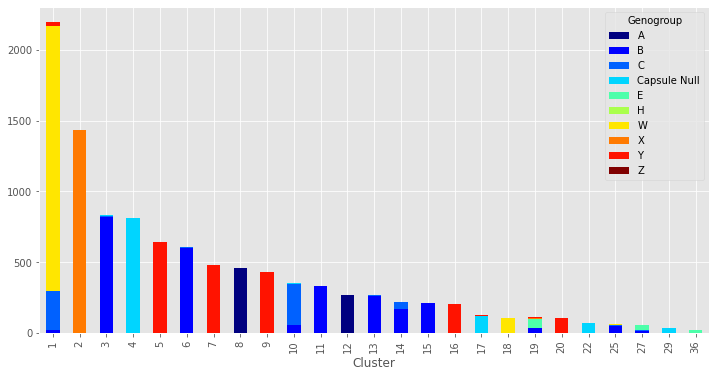

In [68]:
sero_plot_df = pd.DataFrame(cluster_and_serogroup[cluster_and_serogroup["Cluster"].isin(relevant_clusters)].groupby(["Cluster", "Genogroup"]).size())
sero_plot_df = sero_plot_df.reset_index(level=['Genogroup'])
sero_plot_df.pivot(columns='Genogroup', values=0).plot.bar(stacked=True, figsize=(12,6))

Having looked at the top 10 largest clusters, it looks like the serogroups are pretty good for the most part. There is some evidence of capsule switching, which looks believable in almost all cases, as they are in low numbers. Cluster 1 looks like it is possibly made up of two seperate serogroup W and C lineages, after a single switching event and expansion of that lineage. We should check to see if these hold up at the ST level, however:

In [30]:
st_data = pd.read_csv("./poppunk_data/srst2_results_summarised.csv")
st_data

Taxon      ST   abcZ adk  aroE   fumC    gdh   pdhC   pgm  \
0      ERS006830      41      3   6     9      5      9      6     9   
1      ERS006833     180      9   6     9      9      9      6     2   
2      ERS006838      41      3   6     9      5      9      6     9   
3      ERS006839    NF*?      9   6  774*  410*?     9*  841*?     2   
4      ERS006840  8094*?      9   6     9    9*?      9   514*     9   
5      ERS006841    1423      9   5     9      9      9      6     2   
6      ERS006842   1097*      9  20     9      9      9     6*     2   
7      ERS006843   8095*    20*   6    63      9      9   515*     9   
8      ERS006846    1656     12   6     9    162      9      6     9   
9      ERS006847   1228*      9   6    15      9      9     6*    18   
10     ERS006848    NF*?      9   5     9      9  669*?     6*     2   
11     ERS006849     180      9   6     9      9      9      6     2   
12     ERS006850     43*     12   6     9      9      9     6*     9   
13     ERS006851   1823*      3   6     9      5      9     6*   156   
14     ERS006852    NF*?  494*?   6     9      5     9*   694*   156   
15     ERS006853    1415      3   6     9     60      9     26     9   
16     ERS006854     47*      9   6     9     14      9     6*     2   
17     ERS006855    NF*?  494*?   6     9      5      9     6*     9   
18     ERS006856    NF*?  494*?   6    9*     60      9     6*  74*?   
19     ERS006857    NF*?  494*?   6     9      5      9      6     9   
20     ERS006858    577*    27*   6     9      5      9     6*     9   
21     ERS006859     43*    12*   6     9      9      9     6*     9   
22     ERS006860     43*     12   6     9      9      9     6*     9   
23     ERS006861    136*    27*   6     9      3      9     6*    16   
24     ERS006862     136     27   6     9      3      9      6    16   
25     ERS006863     NF*      9  20     9      9      9   694*     2   
26     ERS006864   1228*      9   6    15      9      9     6*    18   
27     ERS006865   1097*      9  20     9      9      9     6*     2   
28     ERS006866    1097      9  20     9      9      9      6     2   
29     ERS006867   1097*      9  20     9      9      9     6*     2   
...          ...     ...    ...  ..   ...    ...    ...    ...   ...   
13691  ERS576476     800      4  10     5      4      6      3     9   
13692  ERS576477   11224      7   5     1    722     36     53    15   
13693  ERS576478     269      4  10    15      9      8     11     9   
13694  ERS576479   10806      3  25    19      5      3      6     9   
13695  ERS576480     154      3   6     9      5     11      6     9   
13696  ERS576481    1157      8  25     7     17     21     26    49   
13697  ERS576482      41      3   6     9      5      9      6     9   
13698  ERS576483      42     10   6     9      5      9      6     9   
13699  ERS576484    2923     17   5     1     17      3     26     2   
13700  ERS576485    1655     12   5    18      9     11      9    17   
13701  ERS576486    3318     23   3    12     25      3     22    12   
13702  ERS576487    8931     23   6     9      9      9      6     9   
13703  ERS576488    2660      7   5     1     13     36      6    15   
13704  ERS576489    1224     11   5    18      8     78     24    21   
13705  ERS576490     213      7   5     1     13     36     53    15   
13706  ERS576491      41      3   6     9      5      9      6     9   
13707  ERS576492    6566      8   5     9      9      9      6     9   
13708  ERS576493      18      7   8    10     19     10      1     2   
13709  ERS576494    6566      8   5     9      9      9      6     9   
13710  ERS576495    3135      8   5     7     17     21     26     2   
13711  ERS576496     213      7   5     1     13     36     53    15   
13712  ERS576497      11      2   3     4      3      8      4     6   
13713  ERS576498    1163      4  10     2      5      3     11     9   
13714  ERS576499    2806     10   6     9      5   

In [32]:
cluster_and_st = pd.merge(refined_newqc_clustering, st_data, on="Taxon", how="inner")

In [35]:
cluster_and_st[cluster_and_serogroup["Cluster"]==1]["ST"].value_counts()

/Users/nm12/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


11         2035
NF*?         42
10651        20
NF*          13
NF           12
181          11
13255?        8
11149         8
1287          6
51            4
9766          4
10284         4
4706          3
11?           3
13920         2
10171         2
473           2
5450          2
3419          2
4977          2
NF?           2
11*           2
9358          2
13255         2
5752          1
475           1
13750         1
11*?          1
6881          1
2724          1
1860          1
8345          1
9767          1
10791         1
52            1
13731         1
10170         1
211*          1
7097          1
13263         1
13729         1
9600          1
13720         1
247           1
67            1
10805*?       1
9927          1
14130         1
12511         1
13919?        1
166           1
165           1
11154         1
15207         1
Name: ST, dtype: int64

In [36]:
cluster_and_st[cluster_and_serogroup["Cluster"]==2]["ST"].value_counts()

/Users/nm12/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


181       1315
11372       42
5789        41
751         12
NF           6
11372?       5
11591        3
11591?       2
181*         2
10169        1
7670         1
NF*?         1
41           1
9359         1
NF*          1
182          1
340          1
Name: ST, dtype: int64

In [37]:
cluster_and_st[cluster_and_serogroup["Cluster"]==3]["ST"].value_counts()

/Users/nm12/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


41       338
485       54
1194      53
42        48
154       44
340       23
40        22
NF        22
2314      15
46        10
NF*?      10
NF*       10
1475       9
192        9
1374       8
1403       6
482        5
2203       5
2016       5
8054       4
7670       4
303        4
1090       4
5981       4
8988       4
7385       4
1992       3
5357       3
2708       3
8052       3
        ... 
5330       1
13714      1
1196       1
12094      1
2989       1
2080       1
13304      1
7697       1
45         1
8229       1
2578       1
6697       1
5452       1
9882       1
10278      1
4586       1
8384       1
5447       1
13716      1
10725      1
8176       1
8511       1
8731       1
10693      1
4257       1
9886       1
13727      1
158        1
9883       1
10270      1
Name: ST, Length: 144, dtype: int64

In [38]:
cluster_and_st[cluster_and_serogroup["Cluster"]==4]["ST"].value_counts()

/Users/nm12/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


192        773
7697        15
192?        11
4375         7
23           4
NF?          2
11598        1
7698         1
11642        1
13406*?      1
Name: ST, dtype: int64

In [39]:
cluster_and_st[cluster_and_serogroup["Cluster"]==5]["ST"].value_counts()

/Users/nm12/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


4375     525
23        95
13353      8
3582       7
8219       5
1625       5
3801       4
4183       4
32         3
7784       1
9353       1
NF         1
4988       1
2696       1
8043       1
265        1
9632       1
NF*?       1
639        1
8411       1
33         1
8049       1
7872       1
10466      1
34         1
5483       1
5455       1
2038       1
1622       1
Name: ST, dtype: int64

In [40]:
cluster_and_st[cluster_and_serogroup["Cluster"]==6]["ST"].value_counts()

/Users/nm12/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


32        185
33        120
34         64
749        55
259        28
3720       14
1655        9
639         8
74          8
13276       7
5151        7
1096        6
23          6
NF*?        6
1880        5
8049        4
5682        4
265         4
6463        3
118         3
2506        3
267         3
290         3
14848       3
2858        3
1100        3
3552        3
1249        2
9989        2
NF          2
         ... 
13276?      1
7301        1
2824        1
10245       1
3764        1
639*        1
11150*      1
10717       1
9775        1
10707       1
2931        1
9072        1
1098        1
4645*       1
7581*?      1
13276*      1
7783        1
7938        1
1015        1
4786        1
2503        1
11278       1
10286       1
3070*       1
12345       1
5955        1
12060       1
13200       1
6083        1
463         1
Name: ST, Length: 77, dtype: int64

In [41]:
cluster_and_st[cluster_and_serogroup["Cluster"]==7]["ST"].value_counts()

/Users/nm12/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


1655      324
23        119
6463       37
7          13
2859        7
12176       6
2692        4
10294       3
11280       3
5           3
NF*         3
NF          2
10732       2
8096        2
9842        1
4245*       1
13170       1
9814        1
4245        1
9831        1
10138       1
10455       1
11280*      1
13353       1
14356       1
5*          1
15206       1
11866       1
4446        1
10458       1
1657        1
Name: ST, dtype: int64

In [42]:
cluster_and_st[cluster_and_serogroup["Cluster"]==8]["ST"].value_counts()

/Users/nm12/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


2859     168
7        143
5         88
2881      29
NF        16
NF*        9
NF*?       6
13365      3
8639       3
9357       2
7?         1
4789       1
9014       1
Name: ST, dtype: int64

In [44]:
cluster_and_st[cluster_and_serogroup["Cluster"]==9]["ST"].value_counts()

/Users/nm12/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


2881     381
11        26
2881*      5
8638       5
175        5
9357       4
5756       2
50         1
4977       1
6395?      1
7928       1
NF*?       1
Name: ST, dtype: int64

In [45]:
cluster_and_st[cluster_and_serogroup["Cluster"]==10]["ST"].value_counts()

/Users/nm12/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


11       294
1161      12
275        8
2704       6
475        3
1163       3
4713       2
50         2
4283       2
3751       1
8950       1
4977       1
7143       1
1159       1
3456       1
10724      1
NF         1
52         1
4993       1
7246       1
NF*        1
5756       1
211        1
2709       1
2994       1
3934       1
4388       1
733        1
9198       1
13715      1
11*        1
15215      1
NF?        1
10260      1
Name: ST, dtype: int64

In [4]:
cluster_and_st = database[["ENA_sample_accessions", "poppunk_cluster", 'ST']]
relevant_clusters = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,22,25,27,29,36]
cluster_and_st.columns = ["ENA_sample_accessions", "Cluster", "ST"]

In [5]:

st_plot_df = pd.DataFrame(cluster_and_st[cluster_and_st["Cluster"].isin(relevant_clusters)].groupby(["Cluster", "ST"]).size())
st_plot_df = st_plot_df.reset_index(level=['ST'])
st_plot_df.pivot(columns='ST', values=0).plot.bar(stacked=True, figsize=(10,7))

TypeError: no numeric data to plot

How actually concordant are PopPUNK clusters and STs? In order to answer this, we need to actually check how the two compare head to head -- how many ST's are there in each cluster, and what fraction of each cluster is dominated by a single ST?

In [42]:
#How concordant are PopPUNK clusters and STs?
#Get PopPUNK clusters
poppunk_clusters = list(set(database["poppunk_cluster"]))
#get ST composition of PopPUNK_clusters, find the biggest
biggest_ST_percentages = {}
for cluster in poppunk_clusters:
    cluster_database = database[database["poppunk_cluster"]==cluster]
    #cluster_size = len(cluster_database["ENA_sample_accessions"])
    ST_counts = cluster_database["ST"].value_counts()
    cluster_size = sum(ST_counts)
    if cluster_size < 10:
        continue
    else:
        biggest_ST_pc = float(max(ST_counts))/float(cluster_size)
        biggest_ST_percentages[cluster] = biggest_ST_pc

In [49]:
{k:v for (k,v) in biggest_ST_percentages.items() if (k in relevant_clusters) and (v < 0.35)}

{6: 0.3027375201288245,
 11: 0.3413173652694611,
 18: 0.25833333333333336,
 36: 0.3181818181818182}

(array([ 4.,  6.,  6., 11., 10.,  5., 14., 15.]),
 array([0.25833333, 0.35104167, 0.44375   , 0.53645833, 0.62916667,
        0.721875  , 0.81458333, 0.90729167, 1.        ]),
 <BarContainer object of 8 artists>)

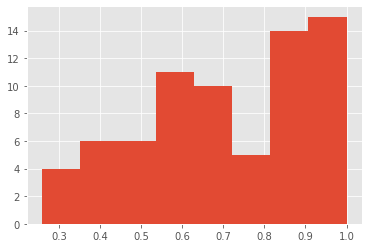

In [47]:
plt.hist(biggest_ST_percentages.values(), bins=8)

What about the number of STs per cluster? We also expect to see a large number of STs at very low frequency due to recent recombination events, is this the case?

In [50]:
#How concordant are PopPUNK clusters and STs?
#Get PopPUNK clusters
poppunk_clusters = list(set(database["poppunk_cluster"]))
#get ST composition of PopPUNK_clusters, find the number of STs
number_of_STs = {}
for cluster in poppunk_clusters:
    cluster_database = database[database["poppunk_cluster"]==cluster]
    #cluster_size = len(cluster_database["ENA_sample_accessions"])
    ST_counts = cluster_database["ST"].value_counts()
    cluster_size = sum(ST_counts)
    if cluster_size < 10:
        continue
    else:
        ST_count = len(ST_counts)
        number_of_STs[cluster] = ST_count

In [55]:
sorted(number_of_STs, key=number_of_STs.get, reverse=True)

[3,
 6,
 11,
 13,
 1,
 15,
 18,
 7,
 14,
 19,
 10,
 5,
 17,
 21,
 25,
 2,
 27,
 8,
 24,
 16,
 20,
 28,
 4,
 12,
 23,
 30,
 39,
 53,
 9,
 22,
 61,
 70,
 37,
 43,
 46,
 50,
 29,
 35,
 36,
 41,
 52,
 62,
 65,
 32,
 56,
 59,
 31,
 34,
 42,
 44,
 45,
 48,
 49,
 54,
 63,
 67,
 71,
 26,
 33,
 38,
 40,
 47,
 51,
 55,
 57,
 60,
 64,
 68,
 69,
 58,
 66]

In [ ]:
#Can we plot number of clusters against the number of 

These results are a bit more concerning, as every cluster in the 10 largest clusters is made up of multiple STs. The low-frequency STs can probably be discounted as instances of recombination of the ST genes, but for clusters with a plurality of dominant ST, could this mean that we are under-clustering with poppunk? We will have to look at the fastbaps core genome clustering, and poppunk core genome tree to find out

In [6]:
fastbaps_clusters = pd.read_csv("./poppunk_data/fastBAPS_clustering.csv")
fastbaps_clusters["fastBAPS_cluster"].value_counts()

7     707
68    660
1     598
66    499
6     466
62    448
58    395
63    385
55    361
61    354
3     344
30    330
57    317
20    313
53    307
39    303
41    283
69    262
52    236
65    232
50    223
31    217
43    215
29    210
8     197
5     197
67    196
48    194
64    191
11    174
     ... 
32    116
49    116
44    114
2     112
35    111
42    111
51    109
36    108
46    106
37    105
33     88
18     87
24     84
26     84
10     78
56     78
4      78
12     78
54     75
19     74
45     71
16     71
22     70
14     67
40     63
34     61
59     51
21     39
23     32
25     19
Name: fastBAPS_cluster, Length: 69, dtype: int64

In [7]:
poppunk_and_fastbaps = pd.merge(refined_newqc_clustering, fastbaps_clusters, on="Taxon", how="inner")

In [8]:
poppunk_and_fastbaps.shape

(13577, 3)

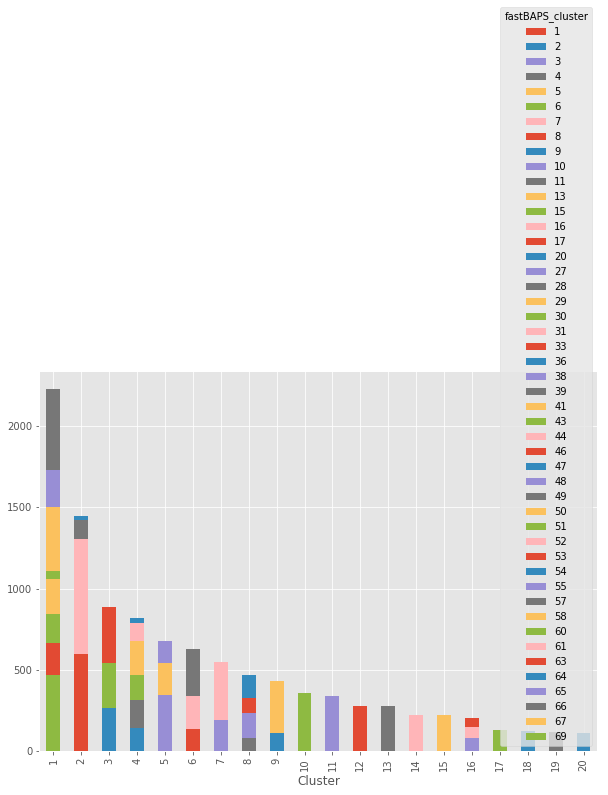

In [9]:
fastbaps_plot_df = pd.DataFrame(poppunk_and_fastbaps[poppunk_and_fastbaps["Cluster"]<=20].groupby(["Cluster", "fastBAPS_cluster"]).size())
fastbaps_plot_df = fastbaps_plot_df.reset_index(level=['fastBAPS_cluster'])
fastbaps_plot_df.pivot(columns='fastBAPS_cluster', values=0).plot.bar(stacked=True, figsize=(10,7))

This looks kind of mediocre -- agreement on clusters, 10, 11, 12, 13, 14, 15, 17, 18, 19, and 20, but having what looks like subclustering in clusters 1-9. We should check these clusters (and 16) to make sure that what we are seeing is subclustering, and not disagreement.

In [31]:
poppunk_and_fastbaps[poppunk_and_fastbaps["Cluster"] == 1]["fastBAPS_cluster"].value_counts()

66    499
6     465
58    395
65    231
50    217
8     197
43    180
51     46
Name: fastBAPS_cluster, dtype: int64

In [35]:
poppunk_and_fastbaps[poppunk_and_fastbaps["fastBAPS_cluster"] == 65]["Cluster"].value_counts()

1      231
563      1
Name: Cluster, dtype: int64

In [50]:
for item in cluster_and_st[cluster_and_serogroup["Cluster"]==4]["Taxon"]:
    print(item)

ERS2922175
ERS4396342
ERS4396214
ERS2798970
ERS2798860
ERS1113662
ERS1113735
ERS2798950
ERS2799079
ERS2922064
ERS2799124
ERS2798823
ERS2798989
ERS4396269
ERS2922022
ERS2799121
ERS2798851
ERS2922055
ERS2798835
ERS4396285
ERS2799172
ERS2799009
ERS2921998
ERS2799105
ERS1113580
ERS2799058
ERS2799166
ERS2798902
ERS2922124
ERS4396703
ERS4396112
ERS2798944
ERS4396287
ERS2922157
ERS2799076
ERS4396381
ERS4396691
ERS1175452
ERS2798947
ERS2799083
ERS4396245
ERS4396787
ERS4396867
ERS1113581
ERS1113586
ERS4396303
ERS2799156
ERS4396311
ERS4396313
ERS2799216
ERS2799025
ERS4396515
ERS2799203
ERS1175412
ERS4396519
ERS2798773
ERS1114494
ERS1067259
ERS1113440
ERS2798832
ERS4396694
ERS4396206
ERS323093
ERS4396805
ERS4396319
ERS2922030
ERS2798959
ERS2798779
ERS1067781
ERS1067533
ERS4396190
ERS1067564
ERS2799125
ERS2799110
ERS4396172
ERS4396343
ERS2799011
ERS4396337
ERS4396197
ERS2922046
ERS2798881
ERS4395949
ERS2799088
ERS2798997
ERS2798909
ERS2922357
ERS4396199
ERS2799023
ERS4396208
ERS2798921
ERS2798763


/Users/nm12/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


What about how these clusters are distributed across continents? Let's make similar graphs to the above in order to take a look

In [12]:
greater_than_100_clusters = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,14,15,16,17,18,19,20,22,25,27,29,36]

In [6]:
#let's get continent data
cluster_and_continent = database[["ENA_sample_accessions", "poppunk_cluster", 'continent']]

In [7]:
cluster_and_continent.columns = ["ENA_sample_accessions", "Cluster", "Continent"]

In [8]:
for x in cluster_and_continent["Cluster"]:
    if "_" in x:
        print(x)

39_248
39_248
39_248
47_1061
184_1122
39_248
39_248
39_248
47_1061
47_1061
39_248
70_382_602
39_248
39_248
39_248
319_596
39_248
319_596
184_1122
39_248
47_1061
39_248
39_248
70_382_602
39_248
47_1061
39_248
39_248
47_1061
47_1061
47_1061
39_248
47_1061
47_1061
47_1061
39_248
47_1061
184_1122
47_1061
47_1061
47_1061
47_1061
39_248
47_1061
70_382_602
70_382_602
319_596
70_382_602
70_382_602
70_382_602
70_382_602
70_382_602
70_382_602
70_382_602
70_382_602
70_382_602
70_382_602
70_382_602
47_1061
319_596
319_596
70_382_602
319_596
319_596
319_596
319_596
319_596
319_596
319_596
184_1122
319_596
319_596
319_596
319_596
319_596
319_596
319_596
319_596
319_596
319_596
184_1122
39_248
319_596
319_596
319_596
184_1122
319_596
319_596
319_596
319_596
319_596
319_596
319_596
319_596
319_596
319_596
319_596
319_596
319_596
39_248
319_596
184_1122
319_596
184_1122
319_596
319_596
319_596
319_596


In [9]:
cluster_and_continent["Cluster"] = cluster_and_continent["Cluster"].replace(['319_596'],'319')
cluster_and_continent["Cluster"] = cluster_and_continent["Cluster"].replace(['39_248'],'39')
cluster_and_continent["Cluster"] = cluster_and_continent["Cluster"].replace(['47_1061'],'47')
cluster_and_continent["Cluster"] = cluster_and_continent["Cluster"].replace(['184_1122'],'184')
cluster_and_continent["Cluster"] = cluster_and_continent["Cluster"].replace(['70_382_602'],'70')

/Users/nm12/anaconda/envs/jupyter/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/nm12/anaconda/envs/jupyter/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/nm12/anaconda/envs/jupyter/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [10]:
cluster_and_continent["Cluster"]= pd.to_numeric(cluster_and_continent["Cluster"])

/Users/nm12/anaconda/envs/jupyter/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


<AxesSubplot:xlabel='Cluster'>

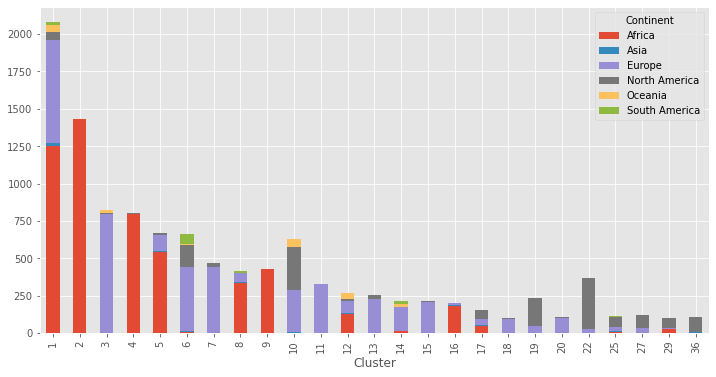

In [13]:
continent_plot_df = pd.DataFrame(cluster_and_continent[cluster_and_continent["Cluster"].isin(greater_than_100_clusters)].groupby(["Cluster", "Continent"]).size())
continent_plot_df = continent_plot_df.reset_index(level=['Continent'])
continent_plot_df.pivot(columns='Continent', values=0).plot.bar(stacked=True, figsize=(12,6))

Let's do disease now too!

In [38]:
#let's get continent data
cluster_and_disease = database[["ENA_sample_accessions", "poppunk_cluster", 'disease']]

cluster_and_disease.columns = ["ENA_sample_accessions", "Cluster", "Disease"]

In [39]:
cluster_and_disease.loc[(cluster_and_disease.Disease == 'Carrier'),'Disease']= "carrier"

/Users/nm12/homebrew/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/nm12/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [40]:
cluster_and_disease["Cluster"] = cluster_and_disease["Cluster"].replace(['319_596'],'319')
cluster_and_disease["Cluster"] = cluster_and_disease["Cluster"].replace(['39_248'],'39')
cluster_and_disease["Cluster"] = cluster_and_disease["Cluster"].replace(['47_1061'],'47')
cluster_and_disease["Cluster"] = cluster_and_disease["Cluster"].replace(['184_1122'],'184')
cluster_and_disease["Cluster"] = cluster_and_disease["Cluster"].replace(['70_382_602'],'70')

/Users/nm12/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/nm12/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/nm12/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

In [42]:
cluster_and_disease["Cluster"] = pd.to_numeric(cluster_and_disease["Cluster"])

/Users/nm12/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


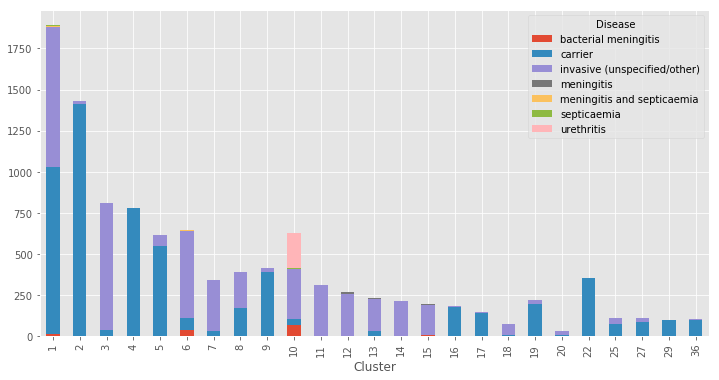

In [48]:
disease_plot_df = pd.DataFrame(cluster_and_disease[cluster_and_disease["Cluster"].isin(greater_than_100_clusters)].groupby(["Cluster", "Disease"]).size())
disease_plot_df = disease_plot_df.reset_index(level=['Disease'])
disease_plot_df.pivot(columns='Disease', values=0).plot.bar(stacked=True, figsize=(12,6))

How are the clusters distributed in time? What is the earliest isolate from each cluster, and where do the early isolates sit in the clustering? Lets look at this and find out!

In [145]:
database[database['year'] < 1950]["poppunk_cluster"].value_counts()

204    3
366    2
365    2
170    2
903    1
897    1
898    1
899    1
228    1
901    1
902    1
894    1
893    1
847    1
848    1
900    1
891    1
892    1
32     1
Name: poppunk_cluster, dtype: int64

Nothing before 1950 is in a major cluster! This is an interesting result. What is the earliest sampling date for a major cluster?

In [142]:
min(database[database['poppunk_cluster'].isin(relevant_clusters)]["year"])

1959.0

Earliest sample is from 1959 -- How are these early samples distributed across clusters though?

In [154]:
database[database['year'] < 1975]["poppunk_cluster"].value_counts() #748 isolates

12     158
14      63
1       57
26      47
8       39
      ... 
889      1
888      1
887      1
886      1
840      1
Name: poppunk_cluster, Length: 208, dtype: int64

In [156]:
database[database['year'] < 1975][database[database['year'] < 1975]["poppunk_cluster"].isin(relevant_clusters)]["poppunk_cluster"].value_counts()

12    158
14     63
1      57
8      39
5      15
10     13
36      6
27      4
18      2
29      1
7       1
2       1
Name: poppunk_cluster, dtype: int64

There are only 360 isolates in major clusters from the 748 isolates before 1975 -- what is the earliest date of isolation for the remaining clusters?

In [160]:
pre_1975_containing_clusters = [1, 2, 5, 7, 8, 10, 12 ,14, 18, 27, 29, 36]
no_pre1975_clusters = list(set(relevant_clusters) - set(pre_1975_containing_clusters)) 
for cluster in no_pre1975_clusters:
    print("Cluster: " + str(cluster))
    print(min(database[database["poppunk_cluster"]==cluster]["year"].dropna()))

Cluster: 3
1982.0
Cluster: 4
2009.0
Cluster: 6
1975.0
Cluster: 9
1978.0
Cluster: 11
1976.0
Cluster: 13
1997.0
Cluster: 15
1994.0
Cluster: 16
2001.0
Cluster: 17
1989.0
Cluster: 19
2009.0
Cluster: 20
2000.0
Cluster: 22
2012.0
Cluster: 25
1993.0


How does this compare with ST results?

In [161]:
database[database['year'] < 1950]["ST"].value_counts()

11277.0    5
4.0        4
8796.0     2
11281.0    1
11283.0    1
11862.0    1
44.0       1
11285.0    1
11.0       1
16.0       1
11276.0    1
57.0       1
11284.0    1
4910.0     1
1.0        1
Name: ST, dtype: int64

In [167]:
pre_1950_clusters = list(database[database['year'] < 1950]["poppunk_cluster"].value_counts().index)
for cluster in pre_1950_clusters:
    print("Cluster: "+str(cluster))
    print(max(database[database["poppunk_cluster"]==cluster]["year"].dropna()))

Cluster: 204
1941.0
Cluster: 366
1942.0
Cluster: 365
1941.0
Cluster: 170
1917.0
Cluster: 903
1944.0
Cluster: 897
1934.0
Cluster: 898
1940.0
Cluster: 899
1940.0
Cluster: 228
1940.0
Cluster: 901
1942.0
Cluster: 902
1943.0
Cluster: 894
1943.0
Cluster: 893
1942.0
Cluster: 847
1944.0
Cluster: 848
1944.0
Cluster: 900
1941.0
Cluster: 891
1937.0
Cluster: 892
1940.0
Cluster: 32
1966.0


In [82]:
#Need to find reference sequences for each cluster -- assigned group of available references to clusters, 
#List of the results for assig
Taxon,Cluster
NZ-05_33-Budroni2011,1
M25074-Retchless2016_W,1
KL11168,1
M22293-TopazBMscan,1
BF1701,1
DL13591,1
M25073-Retchless2016_W,1
M22797-Retchless2016_w,1
M22747-Retchless2016_W,1
ERS2071237,1
H44_76,2
L91543-Karlyshev2015,3_298_1178
NCTC9714,3_298_1178
alpha14-Schoen2008,4
DE8555-Klughammer2017_ID,5
M26417-Kretz2017MSM,6
FDAARGOS_209,6
G2136-Budroni2011,6
B6116_77-Sieb2015ModA,8
Nm331401-Zhu2017XfromA,8
M25964-TopazBMscan,10
M26263-Kretz2017MSM,10
M04-240196-Budroni2011,10
NCTC10026,12
M01-240149-Budroni2011,15_30
FDAARGOS_215,14
AR00441,14
Z2491,17
NCTC12163,26
WUE2121-Klughammer2017,26
DL20404,38
MC58,170
FAM18,170
NCTC8554,249
M21271-Retchless2016,349
NCTC3372,893
FDAARGOS_210,1190
FDAARGOS_211,1191
FDAARGOS_212,1192
FDAARGOS_214,1193
NCTC10025,1194
NCTC6455,1195
NCTC8249,1196
Nm053442-Peng2008,1197

SyntaxError: invalid token (<ipython-input-82-e147e7bfb4c3>, line 2)

In [83]:
cluster_and_serogroup[cluster_and_serogroup["Cluster"]==170]

Taxon  Cluster         Serogroup Contamination_t_or_f
12240  ERS3551974      170                 A                  NaN
12241  ERS3551975      170                 A                  NaN
12242   ERS006987      170  coverage too low                  NaN

In [84]:
cluster_and_st[cluster_and_st["Cluster"]==170]

Taxon  Cluster  ST abcZ adk aroE fumC gdh pdhC pgm mismatches  \
12185  ERS3551974      170   4    1   3    3    1   4    2   3          0   
12186  ERS3551975      170   4    1   3    3    1   4    2   3          0   
12187   ERS006987      170  NF  815   3    3    1   4    2   3          0   

      uncertainty          depth           maxMAF  
12185           -  55.5977142857   0.108108108108  
12186           -  74.3337142857  0.0434782608696  
12187           -  40.9272857143              0.5

In [95]:
#write out lists of individual clusters -- get clusters into writeable format
dic_of_clusters = {}
count = 0
for row in refined_newqc_clustering.iterrows():
    count +=1 
    dic_of_clusters[row[1]["Cluster"]] = dic_of_clusters.get(row[1]["Cluster"], [])
    dic_of_clusters[row[1]["Cluster"]].append(row[1]["Taxon"])

In [97]:
#actually write out the cluster lists
for cluster in dic_of_clusters:
    if cluster <= 20:
        outname = "./poppunk_data/cluster_" + str(cluster)+".txt"
        with open(outname, "w+") as outhandle:
            for isolate_id in dic_of_clusters[cluster]:
                outhandle.write(isolate_id + '\n')
    else:
        outname = "./poppunk_data/clusters_21_to_1187.txt"
        with open(outname, "a") as outhandle:
            for isolate_id in dic_of_clusters[cluster]:
                outhandle.write(isolate_id + '\n')

In [27]:
#What's going on with that 1915 sample?
database[database["year"] < 1950][["ENA_sample_accessions", "ENA_run_accessions", "country", "year", "seroba_prediction", "poppunk_cluster"]]

ENA_sample_accessions ENA_run_accessions  country    year  \
11603            ERS3551973                NaN      USA  1930.0   
11607            ERS3551974                NaN      USA  1917.0   
11611            ERS3551975                NaN      USA  1915.0   
11615            ERS3551976                NaN      USA  1917.0   
11935            ERS3552360                NaN      USA  1917.0   
11938            ERS3552361                NaN      USA  1937.0   
11942            ERS3552362                NaN      USA  1940.0   
11945            ERS3552363                NaN      USA  1941.0   
11947            ERS3552364                NaN      USA  1942.0   
11950            ERS3552365                NaN      USA  1943.0   
11962            ERS3552369                NaN  Denmark  1934.0   
11965            ERS3552370                NaN  Denmark  1940.0   
11970            ERS3552371                NaN  Denmark  1940.0   
11973            ERS3552372                NaN  Denmark  1940.0   
11976            ERS3552373                NaN  Denmark  1941.0   
11979            ERS3552374                NaN  Denmark  1941.0   
11982            ERS3552375                NaN  Denmark  1941.0   
11985            ERS3552376                NaN  Denmark  1942.0   
11988            ERS3552377                NaN  Denmark  1942.0   
11989            ERS3552378                NaN  Denmark  1942.0   
11992            ERS3552379                NaN  Denmark  1943.0   
11995            ERS3552380                NaN  Denmark  1944.0   
12011            ERS3552190                NaN  Denmark  1944.0   
12013            ERS3552191                NaN  Denmark  1944.0   

      seroba_prediction  poppunk_cluster  
11603                 A               32  
11607                 A              170  
11611                 A              170  
11615                 B              204  
11935                 B              204  
11938                 C              891  
11942                 C              892  
11945                 B              204  
11947                 B              893  
11950                 A              894  
11962                 B              897  
11965                 B              228  
11970                 B              898  
11973                 B              899  
11976                 B              365  
11979                 B              900  
11982                 B              365  
11985                 B              366  
11988                 B              366  
11989                 A              901  
11992                 C              902  
11995                 B              903  
12011                 B              847  
12013                 B              848

In [23]:
database

Index(['ENA_sample_accessions', 'ENA_run_accessions', 'data_loc',
       'project_accession', 'species', 'year', 'country', 'disease', 'region',
       'continent', 'date_sampled', 'sex', 'epidemiological_year', 'age_yr',
       'age_mth', 'id', 'isolate', 'aliases', 'serogroup', 'genogroup',
       'genogroup_notes', 'capsule_group', 'MLEE_designation', 'serotype',
       'sero_subtype', 'ET_no', 'penicillin', 'penicillin_range',
       'amoxicillin', 'sulphonamide', 'ceftriaxone', 'ceftriaxone_range',
       'chloramphenicol', 'chloramphenicol_range', 'cefotaxime',
       'cefotaxime_range', 'rifampicin', 'rifampicin_range', 'ciprofloxacin',
       'ciprofloxacin_range', 'tetracycline', 'cefixime', 'azithromycin',
       'spectinomycin', 'bioproject_accession', 'biosample_accession',
       'pMLST_ENA', 'private_project', 'comments', 'sender', 'curator',
       'date_entered', 'datestamp', 'references', 'pMLST_ENA_run_accessions',
       'ENA_comments', 'ENA_sender', 'ENA_datestamp',

In [2]:
clustering_including_USA = pd.read_csv("./poppunk_data/with_US_clusters.csv")

In [9]:
postUS_relevant_clusters = clustering_including_USA["Cluster"].value_counts()[clustering_including_USA["Cluster"].value_counts() > 100].index

In [11]:
postUS_relevant_clusters

Index(['1', '2', '3_509_1153', '4', '6', '5', '10', '7', '8', '9', '22', '11',
       '13', '19', '12', '15', '14', '16', '17', '27_120_608_619', '25_497',
       '18', '36', '20', '29'],
      dtype='object')

In [64]:
clustering_including_USA[clustering_including_USA["Cluster"]=="29"].to_csv("./poppunk_data/cluster_29.US.txt", index=False)

In [14]:
database[database["poppunk_cluster"].astype(int) <7]

ENA_sample_accessions ENA_run_accessions  \
3                 ERS046592          ERR063495   
4                 ERS046594          ERR063497   
5                 ERS046595          ERR063498   
6                 ERS046591          ERR063494   
46                ERS094656          ERR133716   
...                     ...                ...   
15258            SRS6405157        SRR11455350   
15260            SRS6405156        SRR11455352   
15269            SRS6405147        SRR11455362   
15311            SRS6404931        SRR11455130   
15330            SRS6397701        SRR11447603   

                                                data_loc project_accession  \
3      /lustre/scratch118/infgen/pathogen/pathpipe/pr...         ERP000144   
4      /lustre/scratch118/infgen/pathogen/pathpipe/pr...         ERP000144   
5      /lustre/scratch118/infgen/pathogen/pathpipe/pr...         ERP000144   
6      /lustre/scratch118/infgen/pathogen/pathpipe/pr...         ERP000144   
46     /lustre/scratch118/infgen/pathogen/pathpipe/pr...         ERP000144   
...                                                  ...               ...   
15258  /lustre/scratch118/infgen/pathogen/pathpipe/pa...               NaN   
15260  /lustre/scratch118/infgen/pathogen/pathpipe/pa...               NaN   
15269  /lustre/scratch118/infgen/pathogen/pathpipe/pa...               NaN   
15311  /lustre/scratch118/infgen/pathogen/pathpipe/pa...               NaN   
15330  /lustre/scratch118/infgen/pathogen/pathpipe/pa...               NaN   

                      species    year         country  disease        region  \
3      Neisseria meningitidis  1997.0              UK  carrier           NaN   
4      Neisseria meningitidis  1997.0              UK  carrier           NaN   
5      Neisseria meningitidis  1997.0              UK  carrier           NaN   
6      Neisseria meningitidis  1997.0              UK  carrier           NaN   
46     Neisseria meningitidis  1993.0  Czech Republic  carrier            OC   
...                       ...     ...             ...      ...           ...   
15258  Neisseria meningitidis  2015.0             USA  carrier  Rhode Island   
15260  Neisseria meningitidis  2015.0             USA  carrier  Rhode Island   
15269  Neisseria meningitidis  2015.0             USA  carrier  Rhode Island   
15311  Neisseria meningitidis  2015.0             USA  carrier  Rhode Island   
15330  Neisseria meningitidis  2016.0             USA  carrier        Oregon   

           continent  ... aroE fumC  gdh  pdhC  pgm  mismatches uncertainty  \
3             Europe  ...    4   24    8     4    6           0           -   
4             Europe  ...    4   23    8     6    6           0           -   
5             Europe  ...    4   23    8     6    6           0           -   
6             Europe  ...    4    3    8     4    6           0           -   
46            Europe  ...    5   35    6     3    8           0           -   
...              ...  ...  ...  ...  ...   ...  ...         ...         ...   
15258  North America  ...  NaN  NaN  NaN   NaN  NaN         NaN         NaN   
15260  North America  ...  NaN  NaN  NaN   NaN  NaN         NaN         NaN   
15269  North America  ...  NaN  NaN  NaN   NaN  NaN         NaN         NaN   
15311  North America  ...  NaN  NaN  NaN   NaN  NaN         NaN         NaN   
15330  North America  ...  NaN  NaN  NaN   NaN  NaN         NaN         NaN   

               depth          maxMAF poppunk_cluster  
3      170.931714286  0.205882352941               1  
4      179.015142857  0.182186234818               1  
5      217.755142857  0.140740740741               1  
6      173.740857143  0.154589371981               1  
46     100.691142857  0.214285714286               6  
...              ...             ...             ...  
15258            NaN             NaN               6  
15260            NaN             NaN               3  
15269            NaN             NaN               6  
15311   

In [32]:
database[database["poppunk_cluster"].isin([1,2,3,4,5,6,7,8,9])].value_counts()

Series([], dtype: int64)

In [87]:
database["ST"] = database.ST.str.replace("*", "")

In [88]:
database["ST"] = database.ST.str.replace("?", "")

In [91]:
database["ST"] = database.ST.str.replace("nan'", "nan")

In [96]:
database["ST"] = pd.to_numeric(database["ST"], errors="coerce")

In [6]:
database["poppunk_cluster"] = [int(x.split("_")[0]) for x in database["poppunk_cluster"].astype(str)]

In [97]:
database[database["poppunk_cluster"]==6]["ST"].value_counts()

32.0       188
33.0       121
34.0        65
749.0       55
259.0       28
          ... 
3070.0       1
2503.0       1
6083.0       1
7938.0       1
10246.0      1
Name: ST, Length: 68, dtype: int64

In [79]:
cc_32 = pd.read_csv("./temp/cc_32.txt", names=["ST"])

In [73]:
database[database["ST"]=="22"]["poppunk_cluster"]

736      18
1401     18
1643     18
1665     18
1735     18
2175     18
2196     18
3114     18
4597     18
4910     18
4965     18
5260     18
7055     18
7264     18
10578    18
11362    18
11416    18
11463    18
Name: poppunk_cluster, dtype: int64

In [103]:
unique_cluster_6_STs = set(database[database["poppunk_cluster"]==6]["ST"]) - set(cc_32["ST"])

In [104]:
{x for x in unique_cluster_6_STs if x==x}

{290.0,
 1098.0,
 2696.0,
 3720.0,
 3764.0,
 4065.0,
 5151.0,
 5455.0,
 7938.0,
 9072.0,
 9834.0,
 10707.0,
 12060.0,
 12345.0,
 13276.0}

In [108]:
database[database["ST"]==10707]

ENA_sample_accessions ENA_run_accessions  \
1963             ERS378960          ERR466865   

                                               data_loc project_accession  \
1963  /lustre/scratch118/infgen/pathogen/pathpipe/pr...         ERP000951   

                     species    year country                       disease  \
1963  Neisseria meningitidis  2013.0      UK  invasive (unspecified/other)   

     region continent  ... aroE fumC gdh  pdhC  pgm  mismatches uncertainty  \
1963  Wales    Europe  ...    5  672   6     3   15           0           -   

              depth          maxMAF poppunk_cluster  
1963  79.3928571429  0.228571428571               6  

[1 rows x 83 columns]

In [226]:
Europe_clusters = set(database[database["continent"]=="Europe"]["poppunk_cluster"].value_counts().index)

notEurope_clusters = set(database[database["continent"]!="Europe"]["poppunk_cluster"].value_counts().index)
#Number of unique clusters
len(Europe_clusters - notEurope_clusters)

696

In [227]:
Africa_clusters = set(database[database["continent"]=="Africa"]["poppunk_cluster"].value_counts().index)
notAfrica_clusters = set(database[database["continent"]!="Africa"]["poppunk_cluster"].value_counts().index)
#Number of unique clusters
len(Africa_clusters - notAfrica_clusters)

68

In [228]:
NA_clusters = set(database[database["continent"]=="North America"]["poppunk_cluster"].value_counts().index)
notNA_clusters = set(database[database["continent"]!="North America"]["poppunk_cluster"].value_counts().index)
#Number of Unique clusters
len(NA_clusters - notNA_clusters)

147

In [197]:
min(database[database["continent"]=="Europe"]["year"].dropna())

1934.0

In [230]:
print(Europe_clusters & set(relevant_clusters))
print(len(Europe_clusters & set(relevant_clusters)))
print(Africa_clusters & set(relevant_clusters))
print(len(Africa_clusters & set(relevant_clusters)))
print(NA_clusters & set(relevant_clusters))
print(len(NA_clusters & set(relevant_clusters)))

{1, 2, 3, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 27, 29, 36}
23
{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 17, 18, 25, 27, 29}
18
{1, 3, 4, 5, 6, 7, 36, 10, 12, 13, 14, 15, 17, 18, 19, 20, 22, 25, 27, 29}
20


In [231]:
major_Europe = Europe_clusters & set(relevant_clusters)
major_Africa = Africa_clusters & set(relevant_clusters)
major_NA = NA_clusters & set(relevant_clusters)

unique_major_Europe = major_Europe - (major_Africa | major_NA)
print(unique_major_Europe)
unique_major_Africa = major_Africa - (major_Europe | major_NA)
print(unique_major_Africa)
unique_major_NA = major_NA - (major_Europe | major_Africa)
print(unique_major_NA)

{11}
{9}
set()


In [233]:
database[database["poppunk_cluster"]==9]["continent"].value_counts()

Africa    427
Name: continent, dtype: int64

In [240]:
with pd.option_context('display.max_rows', None):
    print(database[database["continent"]=="Europe"]["poppunk_cluster"].value_counts())

3       793
1       690
7       443
6       425
11      331
10      286
13      225
15      203
14      158
20      102
5       102
18       93
12       81
8        62
21       62
23       55
19       50
24       42
17       34
27       34
25       30
30       30
22       26
28       25
33       22
37       20
45       17
16       16
48       14
39       14
43       14
57       13
59       13
55       13
46       12
62       12
42       12
51       11
44       11
66       11
31       11
63       10
64       10
35       10
50       10
71       10
65       10
82        8
56        8
76        8
67        8
77        7
92        7
86        7
88        7
106       6
107       6
99        6
98        6
83        6
49        6
103       6
52        6
81        6
61        6
101       6
105       6
100       6
96        5
87        5
126       5
114       5
122       5
113       5
118       5
29        5
123       5
119       5
156       4
164       4
134       4
145       4
148       4
146 

In [241]:
with pd.option_context('display.max_rows', None):
    print(database[database["continent"]=="Africa"]["poppunk_cluster"].value_counts())

2       1432
1       1254
4        799
5        540
9        427
8        335
16       183
12       130
26        47
17        47
29        26
32        26
34        24
38        18
14        13
74         9
60         8
25         7
89         7
90         7
68         6
125        5
115        5
160        4
138        4
6          4
195        3
180        3
85         3
179        3
10         3
181        3
178        3
182        3
194        3
367        2
349        2
381        2
380        2
325        2
363        2
323        2
53         2
388        2
269        2
324        2
270        2
387        2
391        2
350        2
326        2
322        2
211        1
783        1
655        1
651        1
563        1
479        1
1140       1
200        1
1136       1
1076       1
788        1
784        1
780        1
772        1
656        1
652        1
203        1
476        1
480        1
786        1
49         1
155        1
654        1
650        1
562        1

In [242]:
with pd.option_context('display.max_rows', None):
    print(database[database["continent"]=="North America"]["poppunk_cluster"].value_counts())

22      342
10      287
19      182
6       148
36       96
27       86
29       66
25       65
17       64
1190     60
1        55
319      42
638      39
13       27
42       26
1191     22
7        22
49       19
30       18
5        17
1192     16
1193     12
61       12
1194     11
58       11
12       11
1195     10
70        8
1196      8
15        8
91        7
496       7
1197      6
1199      5
1198      5
23        5
184       5
286       5
124       5
56        5
50        4
1200      4
161       4
75        4
68        4
154       4
18        4
14        4
3         4
1201      4
28        3
21        3
24        3
20        3
1004      3
201       3
1203      3
142       3
1205      3
505       3
1204      3
1207      3
1209      3
1202      3
204       3
1206      3
1208      3
1217      2
1216      2
1008      2
43        2
39        2
1218      2
1221      2
1220      2
81        2
170       2
1222      2
1210      2
1215      2
1213      2
1211      2
67        2
84  

# Let's now gather some facts about the different clusters with relation to their geography, disease, serogroups and STs

In [ ]:
#print disease percentages
for cluster in relevant_clusters:
    cldb = database[database["poppunk_cluster"]==cluster]
    

In [491]:
min(database[database["poppunk_cluster"]==36]["year"].value_counts().index)

1970.0

In [562]:
database[database["ST"]=="11372"]["poppunk_cluster"].value_counts()

2      47
655     1
650     1
Name: poppunk_cluster, dtype: int64

In [579]:
database[database["poppunk_cluster"]==7]["continent"].value_counts()

Europe           443
North America     22
Oceania            2
Africa             1
Name: continent, dtype: int64

In [580]:
sum(database[database["poppunk_cluster"]==7]["continent"].value_counts())



468

In [521]:
54/881

0.06129398410896708

In [498]:
database[database["project_accession"]=="ERP014166"]["poppunk_cluster"].value_counts()

2      1353
5       537
1       373
9       180
16      135
4        90
8        86
29       22
34       12
74        9
115       5
138       4
180       3
178       3
182       3
269       2
38        1
481       1
476       1
478       1
479       1
23        1
85        1
179       1
181       1
477       1
480       1
Name: poppunk_cluster, dtype: int64

In [499]:
1353/2838

0.47674418604651164

In [504]:
database[database["year"]<1950]["seroba_prediction"]

ENA_sample_accessions
ERS3551973    A
ERS3551974    A
ERS3551975    A
ERS3551976    B
ERS3552360    B
ERS3552361    C
ERS3552362    C
ERS3552363    B
ERS3552364    B
ERS3552365    A
ERS3552369    B
ERS3552370    B
ERS3552371    B
ERS3552372    B
ERS3552373    B
ERS3552374    B
ERS3552375    B
ERS3552376    B
ERS3552377    B
ERS3552378    A
ERS3552379    C
ERS3552380    B
ERS3552190    B
ERS3552191    B
Name: seroba_prediction, dtype: object

In [565]:
database["poppunk_cluster"].value_counts()

1       2218
2       1436
3        881
4        816
6        733
        ... 
868        1
860        1
852        1
844        1
1279       1
Name: poppunk_cluster, Length: 1262, dtype: int64

In [569]:
len(database[(database["country"] == "Burkina Faso") & (database["year"]>=2009)]["poppunk_cluster"].value_counts())

27

In [ ]:
database[(database["country"] == "USA") & (database["year"]>=2009)][""].value_counts()

In [604]:
database[database["ST"]==""]["poppunk_cluster"].value_counts()

Series([], Name: poppunk_cluster, dtype: int64)

In [575]:
database[database["continent"]=="South America"]["poppunk_cluster"].value_counts())

6       66
14      22
41      19
40      19
1       15
        ..
342      1
1108     1
1107     1
1106     1
768      1
Name: poppunk_cluster, Length: 68, dtype: int64

In [577]:
database[database["country"]=="Brazil"]["poppunk_cluster"].value_counts()

6      35
40     19
41     19
1      10
8       7
58      6
121     5
199     3
44      3
335     2
343     2
352     2
353     2
354     2
336     2
807     1
70      1
10      1
799     1
812     1
815     1
800     1
801     1
802     1
803     1
804     1
814     1
813     1
805     1
811     1
810     1
806     1
67      1
739     1
808     1
708     1
737     1
736     1
735     1
734     1
733     1
732     1
731     1
730     1
710     1
709     1
707     1
334     1
706     1
705     1
704     1
703     1
702     1
701     1
838     1
809     1
342     1
738     1
768     1
Name: poppunk_cluster, dtype: int64

In [606]:
database[database["ST"]=="823"]["poppunk_cluster"].value_counts()

22     330
387      2
Name: poppunk_cluster, dtype: int64

In [601]:
database[database["poppunk_cluster"]==20]["year"].value_counts()

2009.0    16
2012.0    10
2011.0     5
2019.0     3
2018.0     3
2007.0     3
2010.0     3
2015.0     2
2013.0     1
2016.0     1
2002.0     1
2000.0     1
Name: year, dtype: int64

In [596]:
240/295

0.8135593220338984

In [612]:
database[database["continent"]=="Asia"]["poppunk_cluster"].value_counts()

1      18
69     11
5      11
54     11
17     10
       ..
117     1
631     1
632     1
635     1
868     1
Name: poppunk_cluster, Length: 104, dtype: int64

In [609]:
database["continent"].value_counts()

Europe           5862
Africa           5476
North America    2115
Asia              246
South America     234
Oceania           225
Name: continent, dtype: int64

In [614]:
database[database["poppunk_cluster"]==15].shape

(228, 82)

In [3]:
#read in dating summaries for quick access
tmrca_dates = pd.read_csv("../lsd/results.csv")

In [5]:
tmrca_dates.sort_values(by="tMRCA")

cluster    tMRCA    negCI    posCI
14       15  1320.47  1096.37  1500.72
20       22  1564.32  1282.97  1663.86
3         4  1666.84  1592.69  1708.85
2         3  1783.10  1702.93  1826.79
7         8  1802.33  1745.45  1841.55
18       19  1818.82  1756.07  1889.79
11       12  1891.87  1876.92  1904.56
5         6  1902.63  1880.65  1915.71
0         1  1934.47  1930.96  1937.40
16       17  1941.01  1922.83  1949.99
13       14  1950.92  1947.66  1953.15
24       36  1956.01  1951.18  1959.06
23       29  1958.21  1957.02  1959.12
9        10  1958.66  1958.41  1958.87
17       18  1966.43  1964.84  1967.53
4         5  1967.12  1966.75  1967.41
22       27  1967.23  1966.55  1967.95
1         2  1967.91  1966.85  1968.81
6         7  1970.00  1969.26  1970.00
12       13  1970.78  1963.56  1975.73
8         9  1975.94  1975.04  1976.61
10       11  1976.00  1975.04  1976.00
21       25  1988.95  1987.74  1989.93
19       20  1990.42  1987.14  1993.18
15       16  1994.05  1992.19  1995.31

In [6]:
#generate filtered list of cytoscape nodes
cytoscape_nodes = pd.read_csv("./poppunk_data/final_clustering/visualise_db_cytoscape.csv")

In [12]:
cytoscape_nodes[cytoscape_nodes["combined_Cluster"].isin(relevant_clusters)].to_csv("./poppunk_data/final_clustering/visualise_db_cytoscape_relevant.csv", index=False)

In [21]:
#get ST and cluster data for ggtree
tree_plotting_database = database[["poppunk_cluster", "ST"]]

In [26]:
tree_plotting_database.loc[(~tree_plotting_database["poppunk_cluster"].isin([str(x) for x in relevant_clusters])), "poppunk_cluster"] = "Minor cluster"

/Users/nm12/anaconda/envs/jupyter/lib/python3.6/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [28]:
tree_plotting_database.to_csv("./poppunk_data/final_clustering/metadata.csv")